# Predict Missing Values With Machine Learning

In this notebook, we will predict missing values in the profile dataset with machine learning. Approximately 12.8% of the profile dataset have missing values for both gender and income. 

Individuals are either missing both income and gender information or are not missing any values at all. In addition, these individuals share the same age of 118. 

It is probable that 118 is the app's default age for filling in missing ages. Hence, they are not the actual ages of these individuals.

Since 12.8% constitutes a huge proportion of the profile dataset, I will prefer not to discard the individuals with missing values. I will use machine learning to predict these missing values rather than imputing them with a constant value such as mean, etc.

In [166]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, log_loss, f1_score
from sklearn.utils import resample
from sklearn.decomposition import PCA
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
#from sklearn.externals import joblib
from sklearn.utils import shuffle
from preprocessing_helper import encode_person_id, encode_offer_id, convert_data_type, encode_channel
from model_helper import do_pca, scree_plot
import pickle
%matplotlib inline

warnings.filterwarnings(action='once')

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Plotting original distributions of the demographics

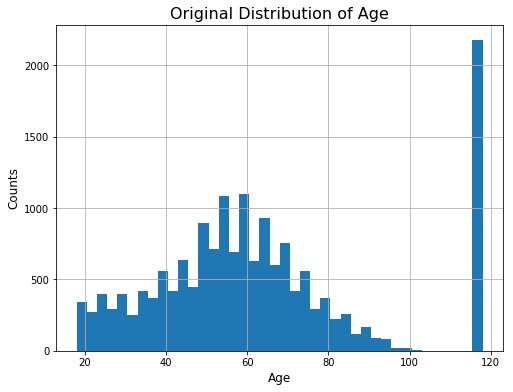

In [3]:
# Original distribution of age
fig, ax = plt.subplots(figsize=(8,6));
profile['age'].hist(bins=40, ax=ax);
ax.set_title("Original Distribution of Age", fontsize=16)
ax.set_xlabel("Age", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

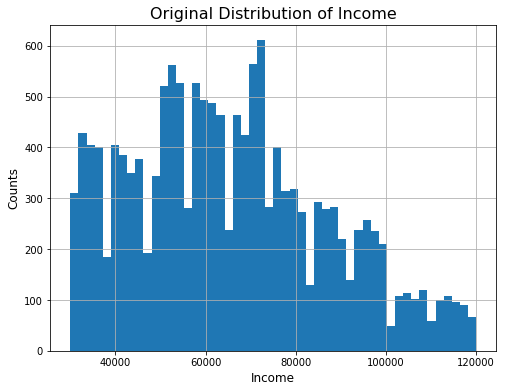

In [4]:
# Original distribution of income
fig, ax = plt.subplots(figsize=(8,6));
profile['income'].hist(bins=50, ax=ax);
ax.set_title("Original Distribution of Income", fontsize=16)
ax.set_xlabel("Income", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

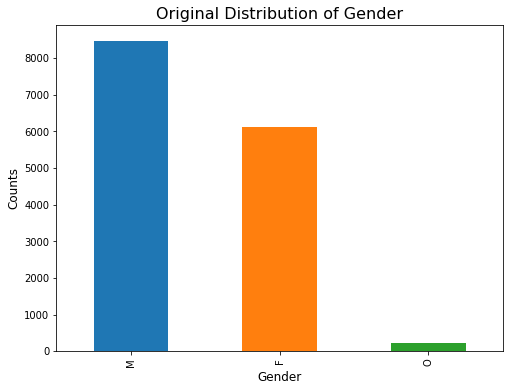

In [5]:
# Original distribution of gender
fig, ax = plt.subplots(figsize=(8,6));
profile['gender'].value_counts().plot(kind='bar', ax=ax);
ax.set_title("Original Distribution of Gender", fontsize=16)
ax.set_xlabel("Gender", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

## Check null values

In [6]:
profile.isnull().mean()

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

In [7]:
profile[profile['gender'].isnull()]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [8]:
profile[profile['gender'].isnull()].age.value_counts()

118    2175
Name: age, dtype: int64

Individuals with missing income information are also missing gender information and vice versa. In addition, these individuals share the same age of 118. It is probable that 118 is the app's default age for filling in missing ages. Hence, they are not the actual ages of these individuals.

## Data Preprocessing

In [6]:
# labele encode original id for customers to integers
profile, transcript, person_enocoder = encode_person_id(profile, transcript)
profile.head()

,age,became_member_on,gender,income,per_id
0,118,20170212,None,NaN,6961
1,55,20170715,F,112000.0,398
2,118,20180712,None,NaN,3746
3,75,20170509,F,100000.0,7996
4,118,20170804,None,NaN,10735


In [7]:
# convert became_member_on to datetime
# and extract year, month, day
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['member_year'] = profile['became_member_on'].dt.year
profile['member_month'] = profile['became_member_on'].dt.month
profile['member_day'] = profile['became_member_on'].dt.day
profile.drop(['became_member_on'], axis=1, inplace=True)

# determine whether row deals with offer or transcation
transcript['value_type'] = transcript['value'].apply(lambda x : list(x.keys())[0])

# extract offer id if its an id, or transcation amount if it is a transcation
transcript['value_id_amt'] = transcript['value'].apply(lambda x : list(x.values())[0])

# ensure data types are consistent

# ensure age, per_id is int
# ensure gender is string
# ensure income is float
int_var_list = ['age', 'per_id']
float_var_list = ['income']
str_var_list = ['gender']
profile = convert_data_type(profile, int_var_list, float_var_list, str_var_list)

# ensure time and per_id are int
# ensure event and value_type are strings
int_var_list = ['time', 'per_id']
str_var_list = ['event', 'value_type']
transcript = convert_data_type(transcript, int_var_list=int_var_list, str_var_list=str_var_list)

I will now seperate the original transcript into two parts: One for offer information and the other for transaction information

In [8]:
# get transcript for offers only
transcript_offer = transcript[(transcript['value_type']=='offer id') | (transcript['value_type']=='offer_id')]
transcript_offer.drop(['value'], axis=1, inplace=True)
transcript_offer.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,event,time,per_id,value_type,value_id_amt
0,offer received,0,7996,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,0,10735,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,0,15043,offer id,2906b810c7d4411798c6938adc9daaa5
3,offer received,0,9524,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,0,6939,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [9]:
# get transcript for transactions only
transcript_trans = transcript[transcript['value_type']=='amount']
transcript_trans.drop(['event', 'value', 'value_type'], axis=1, inplace=True)
transcript_trans.rename(index=str, columns={"time":"time_spent", "value_id_amt":"amt_spent"}, inplace=True)
transcript_trans.head()

,time_spent,per_id,amt_spent
12654,0,169,0.83
12657,0,10701,34.56
12659,0,5627,13.23
12670,0,11984,19.51
12671,0,16908,18.97


In [10]:
# label encode id for offers from hash values to integers
portfolio, transcript_offer, offer_encoder = encode_offer_id(portfolio, transcript_offer)

C:\Users\Josh Lee\Documents\Udacity\Data_Scientist_Nanodegree\capstone\preprocessing_helper.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  transcript_offer_df['offer_id'] = offer_encoder.transform(transcript_offer_df['value_id_amt'])


In [11]:
# one-hot encode channels in portfolio
portfolio = encode_channel(portfolio)
portfolio

,difficulty,duration,offer_type,reward,offer_id,email,mobile,social,web
0,10,7,bogo,10,7,1,1,1,0
1,10,5,bogo,10,4,1,1,1,1
2,0,4,informational,0,3,1,1,0,1
3,5,7,bogo,5,6,1,1,0,1
4,20,10,discount,5,0,1,0,0,1
5,7,7,discount,3,1,1,1,1,1
6,10,10,discount,2,9,1,1,1,1
7,0,3,informational,0,5,1,1,1,0
8,5,5,bogo,5,8,1,1,1,1
9,10,7,discount,2,2,1,1,0,1


In [12]:
# merge transcript_offer with profile
transcript_offer = pd.merge(transcript_offer, profile, how='left', on='per_id')

# merge transcript_offer with portfolio
transcript_offer = pd.merge(transcript_offer, portfolio, how='left', on='offer_id')

In [13]:
transcript_offer.head()

,event,time,per_id,offer_id,age,gender,income,member_year,member_month,member_day,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer received,0,7996,6,75,F,100000.0,2017,5,9,5,7,bogo,5,1,1,0,1
1,offer received,0,10735,0,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1
2,offer received,0,15043,2,68,M,70000.0,2018,4,26,10,7,discount,2,1,1,0,1
3,offer received,0,9524,9,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1
4,offer received,0,6939,4,118,None,NaN,2017,10,2,10,5,bogo,10,1,1,1,1


I will now split transcript_offer into 3 different dataframes: One tracking when offers are received, the other tracking when offers are viewed and the last tracking when offers are completed. Doing so will allow us to merge all 3 together to obtain a summary of the offers. Some of the offers obtained through the merging process will be nonsensical offers. We will need to eliminate such offers.

In [14]:
# generate dataframe tracking when offers received
transcript_offer_received = transcript_offer[transcript_offer['event']=='offer received']
transcript_offer_received.rename(index=str, columns={"time":"time_received"}, inplace=True)
transcript_offer_received.drop(['event'], axis=1, inplace=True)
transcript_offer_received.head()

,time_received,per_id,offer_id,age,gender,income,member_year,member_month,member_day,difficulty,duration,offer_type,reward,email,mobile,social,web
0,0,7996,6,75,F,100000.0,2017,5,9,5,7,bogo,5,1,1,0,1
1,0,10735,0,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1
2,0,15043,2,68,M,70000.0,2018,4,26,10,7,discount,2,1,1,0,1
3,0,9524,9,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1
4,0,6939,4,118,None,NaN,2017,10,2,10,5,bogo,10,1,1,1,1


In [15]:
# generate dataframe tracking when offers viewed
transcript_offer_viewed = transcript_offer[transcript_offer['event']=='offer viewed']
transcript_offer_viewed.rename(index=str, columns={"time":"time_viewed"}, inplace=True)
cols_to_drop = ['event', 'age', 'gender', 'income', 'member_year', 'member_month',\
                'member_day', 'difficulty', 'duration', 'offer_type', 'reward',\
                'email', 'mobile', 'social', 'web']
transcript_offer_viewed.drop(cols_to_drop, axis=1, inplace=True)
transcript_offer_viewed.head()

,time_viewed,per_id,offer_id
12650,0,3728,8
12651,0,13994,5
12652,0,1051,4
12653,0,169,7
12654,0,12743,5


In [16]:
# generate dataframe tracking when offers completed
transcript_offer_completed = transcript_offer[transcript_offer['event']=='offer completed']
transcript_offer_completed.rename(index=str, columns={"time":"time_completed"}, inplace=True)
transcript_offer_completed.drop(cols_to_drop, axis=1, inplace=True)
transcript_offer_completed.head()

,time_completed,per_id,offer_id
12656,0,10701,2
12667,0,16908,9
12673,0,6534,6
12683,0,6862,7
12687,0,9576,4


In [17]:
# merge all 3 together
all_offers = pd.merge(transcript_offer_received, transcript_offer_viewed, on=['per_id', 'offer_id'], how='left')
all_offers = pd.merge(all_offers, transcript_offer_completed, on=['per_id', 'offer_id'], how='left')
all_offers.head()

,time_received,per_id,offer_id,age,gender,income,member_year,member_month,member_day,difficulty,duration,offer_type,reward,email,mobile,social,web,time_viewed,time_completed
0,0,7996,6,75,F,100000.0,2017,5,9,5,7,bogo,5,1,1,0,1,6.0,132.0
1,0,10735,0,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1,6.0,NaN
2,0,10735,0,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1,624.0,NaN
3,0,15043,2,68,M,70000.0,2018,4,26,10,7,discount,2,1,1,0,1,18.0,NaN
4,0,9524,9,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1,12.0,NaN


At this stage, alot of offers generated through the merging process are false offers. We will try to eliminate these offers.

We will now keep keep only offers that meet the following conditions:

1. (time offer viewed > time offer received) and (time offer completed > time offer viewed)
2. (time offer viewed > time offer received) and (time completed is null)
3. both time offer viewed and time offer completed are null

Offers that do not meet these conditions are false offers and will be discarded.

In [69]:
# add time of offer expiry column. This will track when offers expires
all_offers['time_expiry'] = all_offers['time_received'] + all_offers['duration']

 
all_offers = all_offers[((all_offers['time_viewed'] >= all_offers['time_received']) &\
                        (all_offers['time_completed'] >= all_offers['time_viewed']))
                        |
                        # offers that are viewed after they are received but not completed
                        ((all_offers['time_viewed'] >= all_offers['time_received']) &\
                        all_offers['time_completed'].isnull())
                        |
                        # offers that are received but not viewed or completed
                        (all_offers['time_viewed'].isnull() &\
                         all_offers['time_completed'].isnull())
                       ]


all_offers.head(10)

,time_received,per_id,offer_id,age,gender,income,member_year,member_month,member_day,difficulty,duration,offer_type,reward,email,mobile,social,web,time_viewed,time_completed,time_expiry
0,0,7996,6,75,F,100000.0,2017,5,9,5,7,bogo,5,1,1,0,1,6.0,132.0,7
1,0,10735,0,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1,6.0,NaN,10
2,0,10735,0,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1,624.0,NaN,10
3,0,15043,2,68,M,70000.0,2018,4,26,10,7,discount,2,1,1,0,1,18.0,NaN,7
4,0,9524,9,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1,12.0,NaN,10
5,0,9524,9,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1,522.0,NaN,10
6,0,6939,4,118,None,NaN,2017,10,2,10,5,bogo,10,1,1,1,1,84.0,NaN,5
7,0,3728,8,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,0.0,60.0,5
8,0,3728,8,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,0.0,600.0,5
10,0,3728,8,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,504.0,600.0,5


Now, we will attempt to classify the offers to their probable outcomes.

Offers that are probably successful will be offers that are viewed sometime after they are received but before the offer is completed. This means that the customer is aware of an offer and is making transactions as a result of the offer. In addition, the offer must be completed before it expires. Likewise the time of vewing must also come before the time of completion.

Offers that are probably tried are offers that are either
1. received, viewed but completed after time of expiration
or 
2. received, viewed before the offer expires but the offer is not completed.

Offers that have failed or are false offers will be offers that do not belong to any of the above two classes.

Right now, the classifications are just probable. We will use the transactions data to re-affirm these classifications. We will check if there are any transactions that occur during these offers.

In [70]:
def probable_successful_offers(df):
    if ((df['time_received'] <= df['time_viewed']) &\
        (df['time_viewed'] <= df['time_completed']) &\
        (df['time_completed'] <= df['time_expiry'])):
        return 1
    else:
        return 0
    
def probable_tried_offers(df):
    if (((df['time_received'] <= df['time_viewed']) &\
         (df['time_viewed'] <= df['time_expiry']) &\
         (df['time_expiry'] < df['time_completed']))
        |\
        ((df['time_received'] <= df['time_viewed']) &\
         (df['time_viewed'] <= df['time_expiry']) &\
         (math.isnan(df['time_completed'])))):
        return 1
    else:
        return 0
    
def probable_failed_offers(df):
    if ((df['successful_offer'] == 1) | (df['tried_offer'] == 1)):
        return 0
    else:
        return 1

all_offers['successful_offer'] = all_offers.apply(probable_successful_offers, axis=1)
all_offers['tried_offer'] = all_offers.apply(probable_tried_offers, axis=1)
all_offers['failed_offer'] = all_offers.apply(probable_failed_offers, axis=1)

In [71]:
all_offers[all_offers['successful_offer']==1][['per_id', 'offer_id', 'time_received', 'time_viewed', 'time_completed', 'time_expiry', 'successful_offer', 'tried_offer', 'failed_offer']].head()

,per_id,offer_id,time_received,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer
52,6862,7,0,0.0,0.0,7,1,0,0
53,10701,2,0,0.0,0.0,7,1,0,0
204,6534,6,0,0.0,0.0,7,1,0,0
335,6562,9,0,0.0,6.0,10,1,0,0
370,9576,4,0,0.0,0.0,5,1,0,0


In [72]:
all_offers[all_offers['tried_offer']==1][['per_id', 'offer_id', 'time_received', 'time_viewed', 'time_completed', 'time_expiry', 'successful_offer', 'tried_offer', 'failed_offer']].head()

,per_id,offer_id,time_received,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer
0,7996,6,0,6.0,132.0,7,0,1,0
1,10735,0,0,6.0,NaN,10,0,1,0
7,3728,8,0,0.0,60.0,5,0,1,0
8,3728,8,0,0.0,600.0,5,0,1,0
39,1051,4,0,0.0,6.0,5,0,1,0


In [73]:
all_offers[all_offers['failed_offer']==1][['per_id', 'offer_id', 'time_received', 'time_viewed', 'time_completed', 'time_expiry', 'successful_offer', 'tried_offer', 'failed_offer']].head()

,per_id,offer_id,time_received,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer
2,10735,0,0,624.0,NaN,10,0,0,1
3,15043,2,0,18.0,NaN,7,0,0,1
4,9524,9,0,12.0,NaN,10,0,0,1
5,9524,9,0,522.0,NaN,10,0,0,1
6,6939,4,0,84.0,NaN,5,0,0,1


We will drop all duplicated entries including those with duplicated time of receival, person id and offer id. No indivduals received the same offer twice during the same day.

These duplicated entries are eraneous entries generated from the merging process.

In [74]:
# check if customers can receive the same offer type more than once in the same day
transcript_offer_received[transcript_offer_received.duplicated(subset=['time_received', 'per_id', 'offer_id'])]

,time_received,per_id,offer_id,age,gender,income,member_year,member_month,member_day,difficulty,duration,offer_type,reward,email,mobile,social,web


In [75]:
all_offers[all_offers.duplicated(subset=['time_received', 'per_id', 'offer_id'])][['per_id', 'offer_id', 'time_received', 'time_viewed', 'time_completed', 'time_expiry', 'successful_offer', 'tried_offer', 'failed_offer']].head()

,per_id,offer_id,time_received,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer
2,10735,0,0,624.0,NaN,10,0,0,1
5,9524,9,0,522.0,NaN,10,0,0,1
8,3728,8,0,0.0,600.0,5,0,1,0
10,3728,8,0,504.0,600.0,5,0,0,1
12,13108,1,0,348.0,NaN,7,0,0,1


In [76]:
# drop all rows with duplicated per_id, offer_id and time_received
# very likely they are doible counting
all_offers.drop_duplicates(subset=['time_received', 'per_id', 'offer_id'], keep='first', inplace=True)

print(all_offers.shape)
print(transcript_offer_received.shape)

(65109, 23)
(76277, 17)


In [77]:
# get subset of offers that are successfully completed or tried
succ_tried_offers = all_offers[(all_offers['successful_offer']==1) | (all_offers['tried_offer']==1)]
succ_tried_offers.head()

,time_received,per_id,offer_id,age,gender,income,member_year,member_month,member_day,difficulty,...,email,mobile,social,web,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer
0,0,7996,6,75,F,100000.0,2017,5,9,5,...,1,1,0,1,6.0,132.0,7,0,1,0
1,0,10735,0,118,None,NaN,2017,8,4,20,...,1,0,0,1,6.0,NaN,10,0,1,0
7,0,3728,8,65,M,53000.0,2018,2,9,5,...,1,1,1,1,0.0,60.0,5,0,1,0
39,0,1051,4,69,F,57000.0,2016,8,14,10,...,1,1,1,1,0.0,6.0,5,0,1,0
44,0,169,7,20,F,30000.0,2016,7,11,10,...,1,1,1,0,0.0,NaN,7,0,1,0


In [78]:
succ_tried_offers.shape

(17314, 23)

We will now do a cross-product between all successful/tried offers and all transactions. We can then check if the spending occurred during the offer by checking if the time of spending.

If an offer is probably successful, then the spending should occur after the offer is received and before the offer is completed.

If an offer is probably tried, then the spending should occur after the offer is received but before the offer has expired.

If transactions occurred while the offer is still valid, then the offer is considered truly successful or tried.

In [79]:
# find all possible cross product successful/tried offers and transactions
succ_tried_offers = pd.merge(succ_tried_offers, transcript_trans, on='per_id', how='left')
succ_tried_offers.head()

,time_received,per_id,offer_id,age,gender,income,member_year,member_month,member_day,difficulty,...,social,web,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer,time_spent,amt_spent
0,0,7996,6,75,F,100000.0,2017,5,9,5,...,0,1,6.0,132.0,7,0,1,0,132.0,19.89
1,0,7996,6,75,F,100000.0,2017,5,9,5,...,0,1,6.0,132.0,7,0,1,0,144.0,17.78
2,0,7996,6,75,F,100000.0,2017,5,9,5,...,0,1,6.0,132.0,7,0,1,0,222.0,19.67
3,0,7996,6,75,F,100000.0,2017,5,9,5,...,0,1,6.0,132.0,7,0,1,0,240.0,29.72
4,0,7996,6,75,F,100000.0,2017,5,9,5,...,0,1,6.0,132.0,7,0,1,0,378.0,23.93


In [80]:
def check_offer_transactions(df):
    if df['successful_offer'] == 1:
        if (df['time_spent'] >= df['time_received']) and (df['time_spent'] <= df['time_completed']):
            return 1
        else:
            return 0
    else:
        if (df['time_spent'] >= df['time_received']) and (df['time_spent'] <= df['time_expiry']):
            return 1
        else:
            return 0

succ_tried_offers['spent_during_offer'] = succ_tried_offers.apply(check_offer_transactions, axis=1)

In [81]:
succ_tried_offers[succ_tried_offers['spent_during_offer']==1][['per_id', 'offer_id', 'time_received', 'time_viewed', 'time_completed', 'time_expiry', 'time_spent', 'amt_spent', 'spent_during_offer']].tail()

,per_id,offer_id,time_received,time_viewed,time_completed,time_expiry,time_spent,amt_spent,spent_during_offer
151268,945,8,576,576.0,NaN,581,576.0,2.59,1
151317,5479,1,576,576.0,672.0,583,576.0,4.59,1
151367,13867,9,576,582.0,600.0,586,582.0,9.9,1
151415,10170,1,576,576.0,582.0,583,582.0,17.13,1
151442,15919,1,576,576.0,576.0,583,576.0,11.75,1


In [82]:
# offers that have transactions occuring during their validity period are very likely to be offers that 
# are actually successful or tried
succ_tried_offers = succ_tried_offers[succ_tried_offers['spent_during_offer']==1]

succ_tried_offers.head()

,time_received,per_id,offer_id,age,gender,income,member_year,member_month,member_day,difficulty,...,web,time_viewed,time_completed,time_expiry,successful_offer,tried_offer,failed_offer,time_spent,amt_spent,spent_during_offer
27,0,169,7,20,F,30000.0,2016,7,11,10,...,0,0.0,NaN,7,0,1,0,0.0,0.83,1
28,0,169,7,20,F,30000.0,2016,7,11,10,...,0,0.0,NaN,7,0,1,0,6.0,1.44,1
55,0,6862,7,37,M,92000.0,2017,5,15,10,...,0,0.0,0.0,7,1,0,0,0.0,18.01,1
63,0,10701,2,42,M,96000.0,2016,1,17,10,...,1,0.0,0.0,7,1,0,0,0.0,34.56,1
182,0,15772,2,118,None,NaN,2018,4,5,10,...,1,0.0,NaN,7,0,1,0,0.0,1.16,1


In the next section, we will now find out:

1. Total number of offers that were successfully completed by each person for each offer type
2. Total number of offers that were tried by each person for each offer type
3. Total amount of money spent by each person on each offer type
4. Total number of transactions carried out by a person for each offer type
5. Average spending per transaction by each person for each offer type
6. Total number of offers of each type received by each person

In [83]:
# count number of successful, tried offers for each individual
succ_tried_offers_unique = succ_tried_offers.drop_duplicates(['time_received', 'per_id', 'offer_id'])
succ_tried_offers_counts = succ_tried_offers_unique.groupby(['per_id', 'offer_id']).agg({'successful_offer':'sum',\
                                                                                         'tried_offer':'sum'
                                                                                        }).reset_index()

succ_tried_offers_counts.rename(index=str, columns={"successful_offer":"n_succ_offers","tried_offer":"n_tried_offers"}, inplace=True)

succ_tried_offers_counts.head(10)

,per_id,offer_id,n_succ_offers,n_tried_offers
0,9,7,0,1
1,18,8,1,0
2,34,4,1,0
3,38,3,0,1
4,39,1,1,0
5,43,9,1,0
6,54,7,1,0
7,60,1,0,1
8,68,0,1,0
9,70,9,1,0


In [ ]:
# check if aggregating is correct

In [84]:
succ_tried_offers_counts[succ_tried_offers_counts['n_tried_offers']>1]

,per_id,offer_id,n_succ_offers,n_tried_offers
181,983,1,0,2
545,2980,7,0,2
592,3213,9,0,2
633,3503,6,0,2
765,4234,9,0,2
1091,6066,1,0,2
1336,7416,7,0,2
1518,8403,1,0,2
1599,8859,1,0,2
1960,10845,7,0,2


In [85]:
succ_tried_offers[succ_tried_offers['per_id']==4234][['per_id', 'offer_id', 'time_received', 'time_viewed', 'time_completed', 'time_expiry', 'time_spent', 'amt_spent', 'spent_during_offer']]

,per_id,offer_id,time_received,time_viewed,time_completed,time_expiry,time_spent,amt_spent,spent_during_offer
2108,4234,9,0,6.0,114.0,10,6.0,3.77,1
64206,4234,9,336,336.0,366.0,346,342.0,6.6,1


In [86]:
# tracks how much money was spent during period of time when offer is active
succ_tried_offers_summary =\
succ_tried_offers.groupby(['per_id', 'offer_id']).agg({'amt_spent': 'sum',\
                                                       'spent_during_offer': 'count'}).reset_index()

succ_tried_offers_summary.rename(index=str,\
                               columns={"amt_spent":"total_offer_spent",\
                                        "spent_during_offer": "total_num_offer_trans"}, inplace=True)

succ_tried_offers_summary['avg_spent_offer_trans'] = succ_tried_offers_summary['total_offer_spent']/(succ_tried_offers_summary['total_num_offer_trans']*1.0)

succ_tried_offers_summary.head()

,per_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans
0,9,7,9.03,1,9.03
1,18,8,27.32,1,27.32
2,34,4,16.72,1,16.72
3,38,3,23.07,1,23.07
4,39,1,8.91,1,8.91


In [87]:
print(succ_tried_offers_counts['per_id'].tolist() == succ_tried_offers_summary['per_id'].tolist())
print(succ_tried_offers_counts['offer_id'].tolist() == succ_tried_offers_summary['offer_id'].tolist())

True
True


In [88]:
succ_tried_offers_summary = pd.merge(succ_tried_offers_summary, succ_tried_offers_counts,\
                                     on=['per_id', 'offer_id'], how='left', validate='one_to_one')

succ_tried_offers_summary.head()

,per_id,offer_id,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers
0,9,7,9.03,1,9.03,0,1
1,18,8,27.32,1,27.32,1,0
2,34,4,16.72,1,16.72,1,0
3,38,3,23.07,1,23.07,0,1
4,39,1,8.91,1,8.91,1,0


In [89]:
# get summary of all offers sent
offers_summary = transcript_offer_received.groupby(['per_id', 'offer_id']).agg({"time_received":"count"}).reset_index()
offers_summary.rename(index=str, columns={"time_received":"n_offers"}, inplace=True)
offers_summary.head()

,per_id,offer_id,n_offers
0,0,2,1
1,0,3,1
2,0,5,1
3,0,8,1
4,0,9,1


In [90]:
offers_summary = pd.merge(offers_summary, succ_tried_offers_summary, on=['per_id', 'offer_id'], how='left')
offers_summary.head()

,per_id,offer_id,n_offers,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers
0,0,2,1,NaN,NaN,NaN,NaN,NaN
1,0,3,1,NaN,NaN,NaN,NaN,NaN
2,0,5,1,NaN,NaN,NaN,NaN,NaN
3,0,8,1,NaN,NaN,NaN,NaN,NaN
4,0,9,1,NaN,NaN,NaN,NaN,NaN


In [91]:
# check if dataframe makes sense
# should be null
offers_summary[(offers_summary['n_succ_offers']>0) & (offers_summary['total_offer_spent'].isnull())]

,per_id,offer_id,n_offers,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers


In [92]:
# check if dataframe makes sense
# should be null
offers_summary[(offers_summary['n_tried_offers']>0) & (offers_summary['total_offer_spent'].isnull())]

,per_id,offer_id,n_offers,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers


In [93]:
# check if dataframe makes sense
# should be null
offers_summary[(offers_summary['n_succ_offers'].isnull()) & (offers_summary['total_offer_spent']>0)]

,per_id,offer_id,n_offers,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers


In [94]:
# check if dataframe makes sense
# should be null
offers_summary[(offers_summary['n_tried_offers'].isnull()) & (offers_summary['total_offer_spent']>0)]

,per_id,offer_id,n_offers,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers


In [95]:
offers_summary.isnull().mean()

per_id                   0.000000
offer_id                 0.000000
n_offers                 0.000000
total_offer_spent        0.951097
total_num_offer_trans    0.951097
avg_spent_offer_trans    0.951097
n_succ_offers            0.951097
n_tried_offers           0.951097
dtype: float64

In [96]:
# fill na with 0
# these individuals never spent any money for offers
offers_summary.fillna(0, inplace= True)
offers_summary.head()

,per_id,offer_id,n_offers,total_offer_spent,total_num_offer_trans,avg_spent_offer_trans,n_succ_offers,n_tried_offers
0,0,2,1,0.0,0.0,0.0,0.0,0.0
1,0,3,1,0.0,0.0,0.0,0.0,0.0
2,0,5,1,0.0,0.0,0.0,0.0,0.0
3,0,8,1,0.0,0.0,0.0,0.0,0.0
4,0,9,1,0.0,0.0,0.0,0.0,0.0


We will now find out:
1. Total amount of non-offer spending
2. Total number of non-offer transactions
3. Average spending per transaxtion for no offer

In [97]:
# find all out non-offer transactions
offer_transactions = succ_tried_offers[['time_spent', 'per_id', 'amt_spent', 'spent_during_offer']]

transactions_labeled = pd.merge(transcript_trans, offer_transactions, on=['time_spent', 'per_id', 'amt_spent'], how='left')

transactions_labeled['spent_during_offer'].fillna(0, inplace=True)

transactions_labeled.head()

,time_spent,per_id,amt_spent,spent_during_offer
0,0,169,0.83,1.0
1,0,10701,34.56,1.0
2,0,5627,13.23,0.0
3,0,11984,19.51,0.0
4,0,16908,18.97,0.0


In [98]:
# find all transactions carried out during no offer conditions
transactions_non_offer = transactions_labeled[transactions_labeled['spent_during_offer']==0]
transactions_non_offer.head()

,time_spent,per_id,amt_spent,spent_during_offer
2,0,5627,13.23,0.0
3,0,11984,19.51,0.0
4,0,16908,18.97,0.0
6,0,12579,0.22,0.0
7,0,11364,18.59,0.0


In [99]:
# Find summary of transaction information for non-promotional situations
non_offer_summary = transactions_non_offer.groupby(['per_id']).agg({'amt_spent': 'sum',\
                                                                    'spent_during_offer': 'count'}).reset_index()

non_offer_summary.rename(index=str,\
                         columns={"amt_spent":"no_offer_total_spent",\
                                  "spent_during_offer": "no_offer_n_trans"}, inplace=True)

non_offer_summary['no_offer_avg_spent_per_trans'] = non_offer_summary['no_offer_total_spent']/(non_offer_summary['no_offer_n_trans']*1.0)


non_offer_summary.head()

,per_id,no_offer_total_spent,no_offer_n_trans,no_offer_avg_spent_per_trans
0,0,127.60,8,15.950000
1,1,4.09,3,1.363333
2,2,79.46,5,15.892000
3,3,196.86,8,24.607500
4,4,154.05,12,12.837500


## Generate ratios tracking transactional behaviors

Since we don't have alot of demographics information to work with, I will create ratios summarizing transactional behaviors of customers. 

For each type of offer, I will now track:
1. Number of offers of this type received
2. Number of offers of this type that were successful
3. Number of offers of this type that were tried
4. Percentage of offers that were successfully completed
5. Percentage of offers that were tried
6. Total amount of money spent on the offer
7. Number of transactions for this offer
8. Average spending per transaction for this offer.

In [100]:
offer_0_summary = offers_summary[offers_summary['offer_id']==0]
offer_1_summary = offers_summary[offers_summary['offer_id']==1]
offer_2_summary = offers_summary[offers_summary['offer_id']==2]
offer_3_summary = offers_summary[offers_summary['offer_id']==3]
offer_4_summary = offers_summary[offers_summary['offer_id']==4]
offer_5_summary = offers_summary[offers_summary['offer_id']==5]
offer_6_summary = offers_summary[offers_summary['offer_id']==6]
offer_7_summary = offers_summary[offers_summary['offer_id']==7]
offer_8_summary = offers_summary[offers_summary['offer_id']==8]
offer_9_summary = offers_summary[offers_summary['offer_id']==9]

In [101]:
offer_0_summary.rename(index=str,\
                       columns={"total_offer_spent":"offer_0_total_spent",\
                                "total_num_offer_trans": "offer_0_n_trans",\
                                "avg_spent_offer_trans": "offer_0_avg_spent_per_trans",\
                                "n_offers": "offer_0_n_offers",\
                                "n_succ_offers": "offer_0_n_succ_offers",\
                                "n_tried_offers": "offer_0_n_tried_offers"
                               }, inplace=True)

offer_0_summary['offer_0_per_succ_offers'] = offer_0_summary['offer_0_n_succ_offers'] / offer_0_summary['offer_0_n_offers']
offer_0_summary['offer_0_per_tried_offers'] = offer_0_summary['offer_0_n_tried_offers'] / offer_0_summary['offer_0_n_offers']

offer_0_summary = offer_0_summary[['per_id', 'offer_0_n_offers', 'offer_0_n_succ_offers', 'offer_0_n_tried_offers',\
                                   'offer_0_per_succ_offers', 'offer_0_per_tried_offers', 'offer_0_total_spent',\
                                   'offer_0_n_trans', 'offer_0_avg_spent_per_trans'
                                  ]]

offer_0_summary.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,per_id,offer_0_n_offers,offer_0_n_succ_offers,offer_0_n_tried_offers,offer_0_per_succ_offers,offer_0_per_tried_offers,offer_0_total_spent,offer_0_n_trans,offer_0_avg_spent_per_trans
6,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,6,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,10,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
offer_1_summary.rename(index=str,\
                       columns={"total_offer_spent":"offer_1_total_spent",\
                                "total_num_offer_trans": "offer_1_n_trans",\
                                "avg_spent_offer_trans": "offer_1_avg_spent_per_trans",\
                                "n_offers": "offer_1_n_offers",\
                                "n_succ_offers": "offer_1_n_succ_offers",\
                                "n_tried_offers": "offer_1_n_tried_offers"
                               }, inplace=True)

offer_1_summary['offer_1_per_succ_offers'] = offer_1_summary['offer_1_n_succ_offers'] / offer_1_summary['offer_1_n_offers']
offer_1_summary['offer_1_per_tried_offers'] = offer_1_summary['offer_1_n_tried_offers'] / offer_1_summary['offer_1_n_offers']

offer_1_summary = offer_1_summary[['per_id', 'offer_1_n_offers', 'offer_1_n_succ_offers', 'offer_1_n_tried_offers',\
                                   'offer_1_per_succ_offers', 'offer_1_per_tried_offers', 'offer_1_total_spent',\
                                   'offer_1_n_trans', 'offer_1_avg_spent_per_trans'
                                  ]]

offer_1_summary.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,per_id,offer_1_n_offers,offer_1_n_succ_offers,offer_1_n_tried_offers,offer_1_per_succ_offers,offer_1_per_tried_offers,offer_1_total_spent,offer_1_n_trans,offer_1_avg_spent_per_trans
7,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,10,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,19,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
offer_2_summary.rename(index=str,\
                       columns={"total_offer_spent":"offer_2_total_spent",\
                                "total_num_offer_trans": "offer_2_n_trans",\
                                "avg_spent_offer_trans": "offer_2_avg_spent_per_trans",\
                                "n_offers": "offer_2_n_offers",\
                                "n_succ_offers": "offer_2_n_succ_offers",\
                                "n_tried_offers": "offer_2_n_tried_offers"
                               }, inplace=True)

offer_2_summary['offer_2_per_succ_offers'] = offer_2_summary['offer_2_n_succ_offers'] / offer_2_summary['offer_2_n_offers']
offer_2_summary['offer_2_per_tried_offers'] = offer_2_summary['offer_2_n_tried_offers'] / offer_2_summary['offer_2_n_offers']

offer_2_summary = offer_2_summary[['per_id', 'offer_2_n_offers', 'offer_2_n_succ_offers', 'offer_2_n_tried_offers',\
                                   'offer_2_per_succ_offers', 'offer_2_per_tried_offers', 'offer_2_total_spent',\
                                   'offer_2_n_trans', 'offer_2_avg_spent_per_trans'
                                  ]]

offer_2_summary.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,per_id,offer_2_n_offers,offer_2_n_succ_offers,offer_2_n_tried_offers,offer_2_per_succ_offers,offer_2_per_tried_offers,offer_2_total_spent,offer_2_n_trans,offer_2_avg_spent_per_trans
0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,6,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,9,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,12,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,13,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
offer_3_summary.rename(index=str,\
                       columns={"total_offer_spent":"offer_3_total_spent",\
                                "total_num_offer_trans": "offer_3_n_trans",\
                                "avg_spent_offer_trans": "offer_3_avg_spent_per_trans",\
                                "n_offers": "offer_3_n_offers",\
                                "n_succ_offers": "offer_3_n_succ_offers",\
                                "n_tried_offers": "offer_3_n_tried_offers"
                               }, inplace=True)

offer_3_summary['offer_3_per_succ_offers'] = offer_3_summary['offer_3_n_succ_offers'] / offer_3_summary['offer_3_n_offers']
offer_3_summary['offer_3_per_tried_offers'] = offer_3_summary['offer_3_n_tried_offers'] / offer_3_summary['offer_3_n_offers']

offer_3_summary = offer_3_summary[['per_id', 'offer_3_n_offers', 'offer_3_n_succ_offers', 'offer_3_n_tried_offers',\
                                   'offer_3_per_succ_offers', 'offer_3_per_tried_offers', 'offer_3_total_spent',\
                                   'offer_3_n_trans', 'offer_3_avg_spent_per_trans'
                                  ]]

offer_3_summary.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,per_id,offer_3_n_offers,offer_3_n_succ_offers,offer_3_n_tried_offers,offer_3_per_succ_offers,offer_3_per_tried_offers,offer_3_total_spent,offer_3_n_trans,offer_3_avg_spent_per_trans
1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,7,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,10,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
offer_4_summary.rename(index=str,\
                       columns={"total_offer_spent":"offer_4_total_spent",\
                                "total_num_offer_trans": "offer_4_n_trans",\
                                "avg_spent_offer_trans": "offer_4_avg_spent_per_trans",\
                                "n_offers": "offer_4_n_offers",\
                                "n_succ_offers": "offer_4_n_succ_offers",\
                                "n_tried_offers": "offer_4_n_tried_offers"
                               }, inplace=True)

offer_4_summary['offer_4_per_succ_offers'] = offer_4_summary['offer_4_n_succ_offers'] / offer_4_summary['offer_4_n_offers']
offer_4_summary['offer_4_per_tried_offers'] = offer_4_summary['offer_4_n_tried_offers'] / offer_4_summary['offer_4_n_offers']

offer_4_summary = offer_4_summary[['per_id', 'offer_4_n_offers', 'offer_4_n_succ_offers', 'offer_4_n_tried_offers',\
                                   'offer_4_per_succ_offers', 'offer_4_per_tried_offers', 'offer_4_total_spent',\
                                   'offer_4_n_trans', 'offer_4_avg_spent_per_trans'
                                  ]]

offer_4_summary.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,per_id,offer_4_n_offers,offer_4_n_succ_offers,offer_4_n_tried_offers,offer_4_per_succ_offers,offer_4_per_tried_offers,offer_4_total_spent,offer_4_n_trans,offer_4_avg_spent_per_trans
11,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,13,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,16,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,17,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,18,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
offer_5_summary.rename(index=str,\
                       columns={"total_offer_spent":"offer_5_total_spent",\
                                "total_num_offer_trans": "offer_5_n_trans",\
                                "avg_spent_offer_trans": "offer_5_avg_spent_per_trans",\
                                "n_offers": "offer_5_n_offers",\
                                "n_succ_offers": "offer_5_n_succ_offers",\
                                "n_tried_offers": "offer_5_n_tried_offers"
                               }, inplace=True)

offer_5_summary['offer_5_per_succ_offers'] = offer_5_summary['offer_5_n_succ_offers'] / offer_5_summary['offer_5_n_offers']
offer_5_summary['offer_5_per_tried_offers'] = offer_5_summary['offer_5_n_tried_offers'] / offer_5_summary['offer_5_n_offers']

offer_5_summary = offer_5_summary[['per_id', 'offer_5_n_offers', 'offer_5_n_succ_offers', 'offer_5_n_tried_offers',\
                                   'offer_5_per_succ_offers', 'offer_5_per_tried_offers', 'offer_5_total_spent',\
                                   'offer_5_n_trans', 'offer_5_avg_spent_per_trans'
                                  ]]

offer_5_summary.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,per_id,offer_5_n_offers,offer_5_n_succ_offers,offer_5_n_tried_offers,offer_5_per_succ_offers,offer_5_per_tried_offers,offer_5_total_spent,offer_5_n_trans,offer_5_avg_spent_per_trans
2,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
offer_6_summary.rename(index=str,\
                       columns={"total_offer_spent":"offer_6_total_spent",\
                                "total_num_offer_trans": "offer_6_n_trans",\
                                "avg_spent_offer_trans": "offer_6_avg_spent_per_trans",\
                                "n_offers": "offer_6_n_offers",\
                                "n_succ_offers": "offer_6_n_succ_offers",\
                                "n_tried_offers": "offer_6_n_tried_offers"
                               }, inplace=True)

offer_6_summary['offer_6_per_succ_offers'] = offer_6_summary['offer_6_n_succ_offers'] / offer_6_summary['offer_6_n_offers']
offer_6_summary['offer_6_per_tried_offers'] = offer_6_summary['offer_6_n_tried_offers'] / offer_6_summary['offer_6_n_offers']

offer_6_summary = offer_6_summary[['per_id', 'offer_6_n_offers', 'offer_6_n_succ_offers', 'offer_6_n_tried_offers',\
                                   'offer_6_per_succ_offers', 'offer_6_per_tried_offers', 'offer_6_total_spent',\
                                   'offer_6_n_trans', 'offer_6_avg_spent_per_trans'
                                  ]]

offer_6_summary.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,per_id,offer_6_n_offers,offer_6_n_succ_offers,offer_6_n_tried_offers,offer_6_per_succ_offers,offer_6_per_tried_offers,offer_6_total_spent,offer_6_n_trans,offer_6_avg_spent_per_trans
10,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,9,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,10,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
offer_7_summary.rename(index=str,\
                       columns={"total_offer_spent":"offer_7_total_spent",\
                                "total_num_offer_trans": "offer_7_n_trans",\
                                "avg_spent_offer_trans": "offer_7_avg_spent_per_trans",\
                                "n_offers": "offer_7_n_offers",\
                                "n_succ_offers": "offer_7_n_succ_offers",\
                                "n_tried_offers": "offer_7_n_tried_offers"
                               }, inplace=True)

offer_7_summary['offer_7_per_succ_offers'] = offer_7_summary['offer_7_n_succ_offers'] / offer_7_summary['offer_7_n_offers']
offer_7_summary['offer_7_per_tried_offers'] = offer_7_summary['offer_7_n_tried_offers'] / offer_7_summary['offer_7_n_offers']

offer_7_summary = offer_7_summary[['per_id', 'offer_7_n_offers', 'offer_7_n_succ_offers', 'offer_7_n_tried_offers',\
                                   'offer_7_per_succ_offers', 'offer_7_per_tried_offers', 'offer_7_total_spent',\
                                   'offer_7_n_trans', 'offer_7_avg_spent_per_trans'
                                  ]]

offer_7_summary.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,per_id,offer_7_n_offers,offer_7_n_succ_offers,offer_7_n_tried_offers,offer_7_per_succ_offers,offer_7_per_tried_offers,offer_7_total_spent,offer_7_n_trans,offer_7_avg_spent_per_trans
13,3,1,0.0,0.0,0.0,0.000000,0.00,0.0,0.00
30,8,1,0.0,0.0,0.0,0.000000,0.00,0.0,0.00
35,9,3,0.0,1.0,0.0,0.333333,9.03,1.0,9.03
44,11,1,0.0,0.0,0.0,0.000000,0.00,0.0,0.00
52,13,1,0.0,0.0,0.0,0.000000,0.00,0.0,0.00


In [109]:
offer_8_summary.rename(index=str,\
                       columns={"total_offer_spent":"offer_8_total_spent",\
                                "total_num_offer_trans": "offer_8_n_trans",\
                                "avg_spent_offer_trans": "offer_8_avg_spent_per_trans",\
                                "n_offers": "offer_8_n_offers",\
                                "n_succ_offers": "offer_8_n_succ_offers",\
                                "n_tried_offers": "offer_8_n_tried_offers"
                               }, inplace=True)

offer_8_summary['offer_8_per_succ_offers'] = offer_8_summary['offer_8_n_succ_offers'] / offer_8_summary['offer_8_n_offers']
offer_8_summary['offer_8_per_tried_offers'] = offer_8_summary['offer_8_n_tried_offers'] / offer_8_summary['offer_8_n_offers']

offer_8_summary = offer_8_summary[['per_id', 'offer_8_n_offers', 'offer_8_n_succ_offers', 'offer_8_n_tried_offers',\
                                   'offer_8_per_succ_offers', 'offer_8_per_tried_offers', 'offer_8_total_spent',\
                                   'offer_8_n_trans', 'offer_8_avg_spent_per_trans'
                                  ]]

offer_8_summary.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,per_id,offer_8_n_offers,offer_8_n_succ_offers,offer_8_n_tried_offers,offer_8_per_succ_offers,offer_8_per_tried_offers,offer_8_total_spent,offer_8_n_trans,offer_8_avg_spent_per_trans
3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,7,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,8,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
offer_9_summary.rename(index=str,\
                       columns={"total_offer_spent":"offer_9_total_spent",\
                                "total_num_offer_trans": "offer_9_n_trans",\
                                "avg_spent_offer_trans": "offer_9_avg_spent_per_trans",\
                                "n_offers": "offer_9_n_offers",\
                                "n_succ_offers": "offer_9_n_succ_offers",\
                                "n_tried_offers": "offer_9_n_tried_offers"
                               }, inplace=True)

offer_9_summary['offer_9_per_succ_offers'] = offer_9_summary['offer_9_n_succ_offers'] / offer_9_summary['offer_9_n_offers']
offer_9_summary['offer_9_per_tried_offers'] = offer_9_summary['offer_9_n_tried_offers'] / offer_9_summary['offer_9_n_offers']

offer_9_summary = offer_9_summary[['per_id', 'offer_9_n_offers', 'offer_9_n_succ_offers', 'offer_9_n_tried_offers',\
                                   'offer_9_per_succ_offers', 'offer_9_per_tried_offers', 'offer_9_total_spent',\
                                   'offer_9_n_trans', 'offer_9_avg_spent_per_trans'
                                  ]]

offer_9_summary.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,per_id,offer_9_n_offers,offer_9_n_succ_offers,offer_9_n_tried_offers,offer_9_per_succ_offers,offer_9_per_tried_offers,offer_9_total_spent,offer_9_n_trans,offer_9_avg_spent_per_trans
4,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,5,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,6,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,7,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
profile.head()

,age,gender,income,per_id,member_year,member_month,member_day
0,118,None,NaN,6961,2017,2,12
1,55,F,112000.0,398,2017,7,15
2,118,None,NaN,3746,2018,7,12
3,75,F,100000.0,7996,2017,5,9
4,118,None,NaN,10735,2017,8,4


In [112]:
# merge everything with profile
all_data = pd.merge(profile, offer_0_summary, on='per_id', how='left')

# merge summaries of offers with all_data
all_data = pd.merge(all_data, offer_1_summary, on='per_id', how='left')
all_data = pd.merge(all_data, offer_2_summary, on='per_id', how='left')
all_data = pd.merge(all_data, offer_3_summary, on='per_id', how='left')
all_data = pd.merge(all_data, offer_4_summary, on='per_id', how='left')
all_data = pd.merge(all_data, offer_5_summary, on='per_id', how='left')
all_data = pd.merge(all_data, offer_6_summary, on='per_id', how='left')
all_data = pd.merge(all_data, offer_7_summary, on='per_id', how='left')
all_data = pd.merge(all_data, offer_8_summary, on='per_id', how='left')
all_data = pd.merge(all_data, offer_9_summary, on='per_id', how='left')
all_data = pd.merge(all_data, non_offer_summary, on='per_id', how='left')

In [113]:
all_data.head()

,age,gender,income,per_id,member_year,member_month,member_day,offer_0_n_offers,offer_0_n_succ_offers,offer_0_n_tried_offers,...,offer_9_n_succ_offers,offer_9_n_tried_offers,offer_9_per_succ_offers,offer_9_per_tried_offers,offer_9_total_spent,offer_9_n_trans,offer_9_avg_spent_per_trans,no_offer_total_spent,no_offer_n_trans,no_offer_avg_spent_per_trans
0,118,None,NaN,6961,2017,2,12,1.0,0.0,0.0,...,0.0,1.0,0.0,0.5,0.74,1.0,0.74,14.62,7.0,2.088571
1,55,F,112000.0,398,2017,7,15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.01,3.0,25.670000
2,118,None,NaN,3746,2018,7,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.30,6.0,2.383333
3,75,F,100000.0,7996,2017,5,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159.27,7.0,22.752857
4,118,None,NaN,10735,2017,8,4,3.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.65,3.0,1.550000


In [114]:
# check there are no duplicates of person id
all_data[all_data.duplicated(['per_id'])]

,age,gender,income,per_id,member_year,member_month,member_day,offer_0_n_offers,offer_0_n_succ_offers,offer_0_n_tried_offers,...,offer_9_n_succ_offers,offer_9_n_tried_offers,offer_9_per_succ_offers,offer_9_per_tried_offers,offer_9_total_spent,offer_9_n_trans,offer_9_avg_spent_per_trans,no_offer_total_spent,no_offer_n_trans,no_offer_avg_spent_per_trans


In [115]:
all_data.isnull().mean()

age                             0.000000
gender                          0.000000
income                          0.127941
per_id                          0.000000
member_year                     0.000000
member_month                    0.000000
member_day                      0.000000
offer_0_n_offers                0.625059
offer_0_n_succ_offers           0.625059
offer_0_n_tried_offers          0.625059
offer_0_per_succ_offers         0.625059
offer_0_per_tried_offers        0.625059
offer_0_total_spent             0.625059
offer_0_n_trans                 0.625059
offer_0_avg_spent_per_trans     0.625059
offer_1_n_offers                0.627941
offer_1_n_succ_offers           0.627941
offer_1_n_tried_offers          0.627941
offer_1_per_succ_offers         0.627941
offer_1_per_tried_offers        0.627941
offer_1_total_spent             0.627941
offer_1_n_trans                 0.627941
offer_1_avg_spent_per_trans     0.627941
offer_2_n_offers                0.630294
offer_2_n_succ_o

In the following section, I will compute the following statistics for each and every customer

1. Total spending
2. Total number of transactions
3. Total number of offers received
4. Total number of successful offers
5. Total number of tried offers
6. Total average spending per transaction

In [116]:
col_to_fill = ['offer_0_n_offers', 'offer_0_n_succ_offers',
       'offer_0_n_tried_offers', 'offer_0_per_succ_offers',
       'offer_0_per_tried_offers', 'offer_0_total_spent',
       'offer_0_n_trans', 'offer_0_avg_spent_per_trans',
       'offer_1_n_offers', 'offer_1_n_succ_offers',
       'offer_1_n_tried_offers', 'offer_1_per_succ_offers',
       'offer_1_per_tried_offers', 'offer_1_total_spent',
       'offer_1_n_trans', 'offer_1_avg_spent_per_trans',
       'offer_2_n_offers', 'offer_2_n_succ_offers',
       'offer_2_n_tried_offers', 'offer_2_per_succ_offers',
       'offer_2_per_tried_offers', 'offer_2_total_spent',
       'offer_2_n_trans', 'offer_2_avg_spent_per_trans',
       'offer_3_n_offers', 'offer_3_n_succ_offers',
       'offer_3_n_tried_offers', 'offer_3_per_succ_offers',
       'offer_3_per_tried_offers', 'offer_3_total_spent',
       'offer_3_n_trans', 'offer_3_avg_spent_per_trans',
       'offer_4_n_offers', 'offer_4_n_succ_offers',
       'offer_4_n_tried_offers', 'offer_4_per_succ_offers',
       'offer_4_per_tried_offers', 'offer_4_total_spent',
       'offer_4_n_trans', 'offer_4_avg_spent_per_trans',
       'offer_5_n_offers', 'offer_5_n_succ_offers',
       'offer_5_n_tried_offers', 'offer_5_per_succ_offers',
       'offer_5_per_tried_offers', 'offer_5_total_spent',
       'offer_5_n_trans', 'offer_5_avg_spent_per_trans',
       'offer_6_n_offers', 'offer_6_n_succ_offers',
       'offer_6_n_tried_offers', 'offer_6_per_succ_offers',
       'offer_6_per_tried_offers', 'offer_6_total_spent',
       'offer_6_n_trans', 'offer_6_avg_spent_per_trans',
       'offer_7_n_offers', 'offer_7_n_succ_offers',
       'offer_7_n_tried_offers', 'offer_7_per_succ_offers',
       'offer_7_per_tried_offers', 'offer_7_total_spent',
       'offer_7_n_trans', 'offer_7_avg_spent_per_trans',
       'offer_8_n_offers', 'offer_8_n_succ_offers',
       'offer_8_n_tried_offers', 'offer_8_per_succ_offers',
       'offer_8_per_tried_offers', 'offer_8_total_spent',
       'offer_8_n_trans', 'offer_8_avg_spent_per_trans',
       'offer_9_n_offers', 'offer_9_n_succ_offers',
       'offer_9_n_tried_offers', 'offer_9_per_succ_offers',
       'offer_9_per_tried_offers', 'offer_9_total_spent',
       'offer_9_n_trans', 'offer_9_avg_spent_per_trans',
       'no_offer_total_spent', 'no_offer_n_trans',
       'no_offer_avg_spent_per_trans']
all_data[col_to_fill] = all_data[col_to_fill].fillna(0.0)

In [117]:
all_data['total_spent'] =\
all_data['offer_0_total_spent'] + all_data['offer_1_total_spent'] +\
all_data['offer_2_total_spent'] + all_data['offer_3_total_spent'] +\
all_data['offer_4_total_spent'] + all_data['offer_5_total_spent'] +\
all_data['offer_6_total_spent'] + all_data['offer_7_total_spent'] +\
all_data['offer_8_total_spent'] + all_data['offer_9_total_spent'] +\
all_data['no_offer_total_spent']

In [118]:
all_data['total_n_trans'] =\
all_data['offer_0_n_trans'] + all_data['offer_1_n_trans'] +\
all_data['offer_2_n_trans'] + all_data['offer_3_n_trans'] +\
all_data['offer_4_n_trans'] + all_data['offer_5_n_trans'] +\
all_data['offer_6_n_trans'] + all_data['offer_7_n_trans'] +\
all_data['offer_8_n_trans'] + all_data['offer_9_n_trans'] +\
all_data['no_offer_n_trans']

In [119]:
all_data['total_n_offers'] =\
all_data['offer_0_n_offers'] + all_data['offer_1_n_offers'] +\
all_data['offer_2_n_offers'] + all_data['offer_3_n_offers'] +\
all_data['offer_4_n_offers'] + all_data['offer_5_n_offers'] +\
all_data['offer_6_n_offers'] + all_data['offer_7_n_offers'] +\
all_data['offer_8_n_offers'] + all_data['offer_9_n_offers']

In [120]:
all_data['total_n_succ_offers'] =\
all_data['offer_0_n_succ_offers'] + all_data['offer_1_n_succ_offers'] +\
all_data['offer_2_n_succ_offers'] + all_data['offer_3_n_succ_offers'] +\
all_data['offer_4_n_succ_offers'] + all_data['offer_5_n_succ_offers'] +\
all_data['offer_6_n_succ_offers'] + all_data['offer_7_n_succ_offers'] +\
all_data['offer_8_n_succ_offers'] + all_data['offer_9_n_succ_offers']

In [121]:
all_data['total_n_tried_offers'] =\
all_data['offer_0_n_tried_offers'] + all_data['offer_1_n_tried_offers'] +\
all_data['offer_2_n_tried_offers'] + all_data['offer_3_n_tried_offers'] +\
all_data['offer_4_n_tried_offers'] + all_data['offer_5_n_tried_offers'] +\
all_data['offer_6_n_tried_offers'] + all_data['offer_7_n_tried_offers'] +\
all_data['offer_8_n_tried_offers'] + all_data['offer_9_n_tried_offers']

In [122]:
all_data['total_avg_spent_per_trans'] = all_data['total_spent'] / all_data['total_n_trans']

In [123]:
all_data.isnull().mean()[:50]

age                            0.000000
gender                         0.000000
income                         0.127941
per_id                         0.000000
member_year                    0.000000
member_month                   0.000000
member_day                     0.000000
offer_0_n_offers               0.000000
offer_0_n_succ_offers          0.000000
offer_0_n_tried_offers         0.000000
offer_0_per_succ_offers        0.000000
offer_0_per_tried_offers       0.000000
offer_0_total_spent            0.000000
offer_0_n_trans                0.000000
offer_0_avg_spent_per_trans    0.000000
offer_1_n_offers               0.000000
offer_1_n_succ_offers          0.000000
offer_1_n_tried_offers         0.000000
offer_1_per_succ_offers        0.000000
offer_1_per_tried_offers       0.000000
offer_1_total_spent            0.000000
offer_1_n_trans                0.000000
offer_1_avg_spent_per_trans    0.000000
offer_2_n_offers               0.000000
offer_2_n_succ_offers          0.000000


In [124]:
all_data.isnull().mean()[50:100]

offer_5_per_succ_offers         0.000000
offer_5_per_tried_offers        0.000000
offer_5_total_spent             0.000000
offer_5_n_trans                 0.000000
offer_5_avg_spent_per_trans     0.000000
offer_6_n_offers                0.000000
offer_6_n_succ_offers           0.000000
offer_6_n_tried_offers          0.000000
offer_6_per_succ_offers         0.000000
offer_6_per_tried_offers        0.000000
offer_6_total_spent             0.000000
offer_6_n_trans                 0.000000
offer_6_avg_spent_per_trans     0.000000
offer_7_n_offers                0.000000
offer_7_n_succ_offers           0.000000
offer_7_n_tried_offers          0.000000
offer_7_per_succ_offers         0.000000
offer_7_per_tried_offers        0.000000
offer_7_total_spent             0.000000
offer_7_n_trans                 0.000000
offer_7_avg_spent_per_trans     0.000000
offer_8_n_offers                0.000000
offer_8_n_succ_offers           0.000000
offer_8_n_tried_offers          0.000000
offer_8_per_succ

In [125]:
all_data['total_avg_spent_per_trans'] = all_data['total_avg_spent_per_trans'].fillna(0.0)

In the following section, I will compute the statistics for each and every individual:

1. Total spending for offers belonging to the family BOGO/Discount/Informational
2. Total number of transactions for offers belonging to the family BOGO/Discount/Informational
3. Total number of offers received for offers belonging to the family BOGO/Discount/Informational
4. Total number of successful offers for offers belonging to the family BOGO/Discount/Informational
5. Total number of tried offers for offers belonging to the family BOGO/Discount/Informational
6. Total average spending per transaction for offers belonging to the family BOGO/Discount/Informational

Note that the promo family type in the code actually meant informational offer family type. A typo was made

In [126]:
all_data['bogo_n_offers'] = all_data['offer_4_n_offers'] + all_data['offer_6_n_offers'] +\
all_data['offer_7_n_offers'] + all_data['offer_8_n_offers']

all_data['bogo_n_succ_offers'] = all_data['offer_4_n_succ_offers'] + all_data['offer_6_n_succ_offers'] +\
all_data['offer_7_n_succ_offers'] + all_data['offer_8_n_succ_offers']

all_data['bogo_n_tried_offers'] = all_data['offer_4_n_tried_offers'] + all_data['offer_6_n_tried_offers'] +\
all_data['offer_7_n_tried_offers'] + all_data['offer_8_n_tried_offers']

all_data['bogo_per_succ_offer'] = all_data['bogo_n_succ_offers'] / all_data['bogo_n_offers']
all_data['bogo_per_tried_offer'] = all_data['bogo_n_tried_offers'] / all_data['bogo_n_offers']

all_data['bogo_total_spent'] = all_data['offer_4_total_spent'] + all_data['offer_6_total_spent'] +\
all_data['offer_7_total_spent'] + all_data['offer_8_total_spent']

all_data['bogo_n_trans'] = all_data['offer_4_n_trans'] + all_data['offer_6_n_trans'] +\
all_data['offer_7_n_trans'] + all_data['offer_8_n_trans']

all_data['bogo_avg_spent_per_trans'] = all_data['bogo_total_spent'] / all_data['bogo_n_trans']

In [127]:
all_data['discount_n_offers'] = all_data['offer_0_n_offers'] + all_data['offer_1_n_offers'] +\
all_data['offer_2_n_offers'] + all_data['offer_9_n_offers']

all_data['discount_n_succ_offers'] = all_data['offer_0_n_succ_offers'] + all_data['offer_1_n_succ_offers'] +\
all_data['offer_2_n_succ_offers'] + all_data['offer_9_n_succ_offers']

all_data['discount_n_tried_offers'] = all_data['offer_0_n_tried_offers'] + all_data['offer_1_n_tried_offers'] +\
all_data['offer_2_n_tried_offers'] + all_data['offer_9_n_tried_offers']

all_data['discount_per_succ_offer'] = all_data['discount_n_succ_offers'] / all_data['discount_n_offers']
all_data['discount_per_tried_offer'] = all_data['discount_n_tried_offers'] / all_data['discount_n_offers']

all_data['discount_total_spent'] = all_data['offer_0_total_spent'] + all_data['offer_1_total_spent'] +\
all_data['offer_2_total_spent'] + all_data['offer_9_total_spent']

all_data['discount_n_trans'] = all_data['offer_0_n_trans'] + all_data['offer_1_n_trans'] +\
all_data['offer_2_n_trans'] + all_data['offer_9_n_trans']

all_data['discount_avg_spent_per_trans'] = all_data['discount_total_spent'] / all_data['discount_n_trans']

In [128]:
all_data['info_n_offers'] = all_data['offer_3_n_offers'] + all_data['offer_5_n_offers']

all_data['info_n_succ_offers'] = all_data['offer_3_n_succ_offers'] + all_data['offer_5_n_succ_offers']

all_data['info_n_tried_offers'] = all_data['offer_3_n_tried_offers'] + all_data['offer_5_n_tried_offers']

all_data['info_per_succ_offer'] = all_data['info_n_succ_offers'] / all_data['info_n_offers']
all_data['info_per_tried_offer'] = all_data['info_n_tried_offers'] / all_data['info_n_offers']

all_data['info_total_spent'] = all_data['offer_3_total_spent'] + all_data['offer_5_total_spent']

all_data['info_n_trans'] = all_data['offer_3_n_trans'] + all_data['offer_5_n_trans']

all_data['info_avg_spent_per_trans'] = all_data['info_total_spent'] / all_data['info_n_trans']

In [129]:
all_data.head()

,age,gender,income,per_id,member_year,member_month,member_day,offer_0_n_offers,offer_0_n_succ_offers,offer_0_n_tried_offers,...,discount_n_trans,discount_avg_spent_per_trans,info_n_offers,info_n_succ_offers,info_n_tried_offers,info_per_succ_offer,info_per_tried_offer,info_total_spent,info_n_trans,info_avg_spent_per_trans
0,118,None,NaN,6961,2017,2,12,1.0,0.0,0.0,...,2.0,2.89,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
1,55,F,112000.0,398,2017,7,15,0.0,0.0,0.0,...,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,118,None,NaN,3746,2018,7,12,0.0,0.0,0.0,...,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,75,F,100000.0,7996,2017,5,9,0.0,0.0,0.0,...,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,118,None,NaN,10735,2017,8,4,3.0,0.0,0.0,...,0.0,NaN,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [130]:
all_data.isnull().mean()[:50]

age                            0.000000
gender                         0.000000
income                         0.127941
per_id                         0.000000
member_year                    0.000000
member_month                   0.000000
member_day                     0.000000
offer_0_n_offers               0.000000
offer_0_n_succ_offers          0.000000
offer_0_n_tried_offers         0.000000
offer_0_per_succ_offers        0.000000
offer_0_per_tried_offers       0.000000
offer_0_total_spent            0.000000
offer_0_n_trans                0.000000
offer_0_avg_spent_per_trans    0.000000
offer_1_n_offers               0.000000
offer_1_n_succ_offers          0.000000
offer_1_n_tried_offers         0.000000
offer_1_per_succ_offers        0.000000
offer_1_per_tried_offers       0.000000
offer_1_total_spent            0.000000
offer_1_n_trans                0.000000
offer_1_avg_spent_per_trans    0.000000
offer_2_n_offers               0.000000
offer_2_n_succ_offers          0.000000


In [131]:
all_data.isnull().mean()[50:100]

offer_5_per_succ_offers         0.000000
offer_5_per_tried_offers        0.000000
offer_5_total_spent             0.000000
offer_5_n_trans                 0.000000
offer_5_avg_spent_per_trans     0.000000
offer_6_n_offers                0.000000
offer_6_n_succ_offers           0.000000
offer_6_n_tried_offers          0.000000
offer_6_per_succ_offers         0.000000
offer_6_per_tried_offers        0.000000
offer_6_total_spent             0.000000
offer_6_n_trans                 0.000000
offer_6_avg_spent_per_trans     0.000000
offer_7_n_offers                0.000000
offer_7_n_succ_offers           0.000000
offer_7_n_tried_offers          0.000000
offer_7_per_succ_offers         0.000000
offer_7_per_tried_offers        0.000000
offer_7_total_spent             0.000000
offer_7_n_trans                 0.000000
offer_7_avg_spent_per_trans     0.000000
offer_8_n_offers                0.000000
offer_8_n_succ_offers           0.000000
offer_8_n_tried_offers          0.000000
offer_8_per_succ

In [132]:
all_data.isnull().mean()[100:150]

bogo_per_tried_offer            0.118118
bogo_total_spent                0.000000
bogo_n_trans                    0.000000
bogo_avg_spent_per_trans        0.928824
discount_n_offers               0.000000
discount_n_succ_offers          0.000000
discount_n_tried_offers         0.000000
discount_per_succ_offer         0.120882
discount_per_tried_offer        0.120882
discount_total_spent            0.000000
discount_n_trans                0.000000
discount_avg_spent_per_trans    0.911294
info_n_offers                   0.000000
info_n_succ_offers              0.000000
info_n_tried_offers             0.000000
info_per_succ_offer             0.379588
info_per_tried_offer            0.379588
info_total_spent                0.000000
info_n_trans                    0.000000
info_avg_spent_per_trans        0.983000
dtype: float64

In [133]:
features_to_fill = ['bogo_per_succ_offer', 'bogo_per_tried_offer', 'bogo_avg_spent_per_trans',\
                    'discount_per_succ_offer', 'discount_per_tried_offer', 'discount_avg_spent_per_trans',\
                    'info_per_succ_offer', 'info_per_tried_offer', 'info_avg_spent_per_trans'
                   ]


all_data[features_to_fill] = all_data[features_to_fill].fillna(0.0)

Decided to fill all the missing values with 0, because null values indicate customers have never received or completed or tried offers from these family types. Since, we are already keeping track of whether the customers did received the offers (e.g. bogo_n_offers, discount_n_offers, info_n_offers, etc), the model should be able to distinguish between the following situations:
1. customers receive the offer but did not act on them
2. customers did not receive the offers at all

In the following section, I will compute the ratios:

1. Proportion of total spending that was spent on offer id 0/.../9 and no_offer
2. Proportion of total spending that was spent on offer family type: BOGO/Discount/Informational
3. Proportion of total number of transactions that was made on offer id 0/.../9 and no_offer
4. Proportion of total number of transactions that was made on offer family type: BOGO/Discount/Informational
5. Proportion of total number of offers received that belongs to offer id 0/.../9
6. Proportion of total number of offers received that belongs to the offer family type: BOGO/Discount/Informational

In [134]:
all_data['offer_0_spent_/_total_spent'] = all_data['offer_0_total_spent'] / all_data['total_spent']
all_data['offer_1_spent_/_total_spent'] = all_data['offer_1_total_spent'] / all_data['total_spent']
all_data['offer_2_spent_/_total_spent'] = all_data['offer_2_total_spent'] / all_data['total_spent']
all_data['offer_3_spent_/_total_spent'] = all_data['offer_3_total_spent'] / all_data['total_spent']
all_data['offer_4_spent_/_total_spent'] = all_data['offer_4_total_spent'] / all_data['total_spent']
all_data['offer_5_spent_/_total_spent'] = all_data['offer_5_total_spent'] / all_data['total_spent']
all_data['offer_6_spent_/_total_spent'] = all_data['offer_6_total_spent'] / all_data['total_spent']
all_data['offer_7_spent_/_total_spent'] = all_data['offer_7_total_spent'] / all_data['total_spent']
all_data['offer_8_spent_/_total_spent'] = all_data['offer_8_total_spent'] / all_data['total_spent']
all_data['offer_9_spent_/_total_spent'] = all_data['offer_9_total_spent'] / all_data['total_spent']

all_data['no_offer_spent_/_total_spent'] = all_data['no_offer_total_spent'] / all_data['total_spent']

all_data['bogo_spent_/_total_spent'] = all_data['bogo_total_spent'] / all_data['total_spent']
all_data['discount_spent_/_total_spent'] = all_data['discount_total_spent'] / all_data['total_spent']
all_data['info_spent_/_total_spent'] = all_data['info_total_spent'] / all_data['total_spent']

In [135]:
all_data['offer_0_n_trans_/_total_n_trans'] = all_data['offer_0_n_trans'] / all_data['total_n_trans']
all_data['offer_1_n_trans_/_total_n_trans'] = all_data['offer_1_n_trans'] / all_data['total_n_trans']
all_data['offer_2_n_trans_/_total_n_trans'] = all_data['offer_2_n_trans'] / all_data['total_n_trans']
all_data['offer_3_n_trans_/_total_n_trans'] = all_data['offer_3_n_trans'] / all_data['total_n_trans']
all_data['offer_4_n_trans_/_total_n_trans'] = all_data['offer_4_n_trans'] / all_data['total_n_trans']
all_data['offer_5_n_trans_/_total_n_trans'] = all_data['offer_5_n_trans'] / all_data['total_n_trans']
all_data['offer_6_n_trans_/_total_n_trans'] = all_data['offer_6_n_trans'] / all_data['total_n_trans']
all_data['offer_7_n_trans_/_total_n_trans'] = all_data['offer_7_n_trans'] / all_data['total_n_trans']
all_data['offer_8_n_trans_/_total_n_trans'] = all_data['offer_8_n_trans'] / all_data['total_n_trans']
all_data['offer_9_n_trans_/_total_n_trans'] = all_data['offer_9_n_trans'] / all_data['total_n_trans']

all_data['no_offer_n_trans_/_total_n_trans'] = all_data['no_offer_n_trans'] / all_data['total_n_trans']

all_data['bogo_n_trans_/_total_n_trans'] = all_data['bogo_n_trans'] / all_data['total_n_trans']
all_data['discount_n_trans_/_total_n_trans'] = all_data['discount_n_trans'] / all_data['total_n_trans']
all_data['info_n_trans_/_total_n_trans'] = all_data['info_n_trans'] / all_data['total_n_trans']

In [136]:
all_data['offer_0_n_offers_/_total_n_offers'] = all_data['offer_0_n_offers'] / all_data['total_n_offers']
all_data['offer_1_n_offers_/_total_n_offers'] = all_data['offer_1_n_offers'] / all_data['total_n_offers']
all_data['offer_2_n_offers_/_total_n_offers'] = all_data['offer_2_n_offers'] / all_data['total_n_offers']
all_data['offer_3_n_offers_/_total_n_offers'] = all_data['offer_3_n_offers'] / all_data['total_n_offers']
all_data['offer_4_n_offers_/_total_n_offers'] = all_data['offer_4_n_offers'] / all_data['total_n_offers']
all_data['offer_5_n_offers_/_total_n_offers'] = all_data['offer_5_n_offers'] / all_data['total_n_offers']
all_data['offer_6_n_offers_/_total_n_offers'] = all_data['offer_6_n_offers'] / all_data['total_n_offers']
all_data['offer_7_n_offers_/_total_n_offers'] = all_data['offer_7_n_offers'] / all_data['total_n_offers']
all_data['offer_8_n_offers_/_total_n_offers'] = all_data['offer_8_n_offers'] / all_data['total_n_offers']
all_data['offer_9_n_offers_/_total_n_offers'] = all_data['offer_9_n_offers'] / all_data['total_n_offers']
all_data['bogo_n_offers_/_total_n_offers'] = all_data['bogo_n_offers'] / all_data['total_n_offers']
all_data['discount_n_offers_/_total_n_offers'] = all_data['discount_n_offers'] / all_data['total_n_offers']
all_data['info_n_offers_/_total_n_offers'] = all_data['info_n_offers'] / all_data['total_n_offers']

In [137]:
all_data.isnull().mean()[:50]

age                            0.000000
gender                         0.000000
income                         0.127941
per_id                         0.000000
member_year                    0.000000
member_month                   0.000000
member_day                     0.000000
offer_0_n_offers               0.000000
offer_0_n_succ_offers          0.000000
offer_0_n_tried_offers         0.000000
offer_0_per_succ_offers        0.000000
offer_0_per_tried_offers       0.000000
offer_0_total_spent            0.000000
offer_0_n_trans                0.000000
offer_0_avg_spent_per_trans    0.000000
offer_1_n_offers               0.000000
offer_1_n_succ_offers          0.000000
offer_1_n_tried_offers         0.000000
offer_1_per_succ_offers        0.000000
offer_1_per_tried_offers       0.000000
offer_1_total_spent            0.000000
offer_1_n_trans                0.000000
offer_1_avg_spent_per_trans    0.000000
offer_2_n_offers               0.000000
offer_2_n_succ_offers          0.000000


In [138]:
all_data.isnull().mean()[50:100]

offer_5_per_succ_offers         0.0
offer_5_per_tried_offers        0.0
offer_5_total_spent             0.0
offer_5_n_trans                 0.0
offer_5_avg_spent_per_trans     0.0
offer_6_n_offers                0.0
offer_6_n_succ_offers           0.0
offer_6_n_tried_offers          0.0
offer_6_per_succ_offers         0.0
offer_6_per_tried_offers        0.0
offer_6_total_spent             0.0
offer_6_n_trans                 0.0
offer_6_avg_spent_per_trans     0.0
offer_7_n_offers                0.0
offer_7_n_succ_offers           0.0
offer_7_n_tried_offers          0.0
offer_7_per_succ_offers         0.0
offer_7_per_tried_offers        0.0
offer_7_total_spent             0.0
offer_7_n_trans                 0.0
offer_7_avg_spent_per_trans     0.0
offer_8_n_offers                0.0
offer_8_n_succ_offers           0.0
offer_8_n_tried_offers          0.0
offer_8_per_succ_offers         0.0
offer_8_per_tried_offers        0.0
offer_8_total_spent             0.0
offer_8_n_trans             

In [139]:
all_data.isnull().mean()[100:150]

bogo_per_tried_offer                 0.000000
bogo_total_spent                     0.000000
bogo_n_trans                         0.000000
bogo_avg_spent_per_trans             0.000000
discount_n_offers                    0.000000
discount_n_succ_offers               0.000000
discount_n_tried_offers              0.000000
discount_per_succ_offer              0.000000
discount_per_tried_offer             0.000000
discount_total_spent                 0.000000
discount_n_trans                     0.000000
discount_avg_spent_per_trans         0.000000
info_n_offers                        0.000000
info_n_succ_offers                   0.000000
info_n_tried_offers                  0.000000
info_per_succ_offer                  0.000000
info_per_tried_offer                 0.000000
info_total_spent                     0.000000
info_n_trans                         0.000000
info_avg_spent_per_trans             0.000000
offer_0_spent_/_total_spent          0.024824
offer_1_spent_/_total_spent       

In [140]:
all_data.isnull().mean()[150:]

offer_2_n_offers_/_total_n_offers     0.000353
offer_3_n_offers_/_total_n_offers     0.000353
offer_4_n_offers_/_total_n_offers     0.000353
offer_5_n_offers_/_total_n_offers     0.000353
offer_6_n_offers_/_total_n_offers     0.000353
offer_7_n_offers_/_total_n_offers     0.000353
offer_8_n_offers_/_total_n_offers     0.000353
offer_9_n_offers_/_total_n_offers     0.000353
bogo_n_offers_/_total_n_offers        0.000353
discount_n_offers_/_total_n_offers    0.000353
info_n_offers_/_total_n_offers        0.000353
dtype: float64

In [141]:
# fill missing values

features_to_fill = ['offer_0_spent_/_total_spent', 'offer_1_spent_/_total_spent',\
                    'offer_2_spent_/_total_spent', 'offer_3_spent_/_total_spent',\
                    'offer_4_spent_/_total_spent', 'offer_5_spent_/_total_spent',\
                    'offer_6_spent_/_total_spent', 'offer_7_spent_/_total_spent',\
                    'offer_8_spent_/_total_spent', 'offer_9_spent_/_total_spent',\
                    'no_offer_spent_/_total_spent', 'bogo_spent_/_total_spent',\
                    'discount_spent_/_total_spent', 'info_spent_/_total_spent',\
                    'offer_0_n_trans_/_total_n_trans', 'offer_1_n_trans_/_total_n_trans',\
                    'offer_2_n_trans_/_total_n_trans', 'offer_3_n_trans_/_total_n_trans',\
                    'offer_4_n_trans_/_total_n_trans', 'offer_5_n_trans_/_total_n_trans',\
                    'offer_6_n_trans_/_total_n_trans', 'offer_7_n_trans_/_total_n_trans',\
                    'offer_8_n_trans_/_total_n_trans', 'offer_9_n_trans_/_total_n_trans',\
                    'no_offer_n_trans_/_total_n_trans', 'bogo_n_trans_/_total_n_trans',\
                    'discount_n_trans_/_total_n_trans', 'info_n_trans_/_total_n_trans',\
                    'offer_0_n_offers_/_total_n_offers', 'offer_1_n_offers_/_total_n_offers',\
                    'offer_2_n_offers_/_total_n_offers', 'offer_3_n_offers_/_total_n_offers',\
                    'offer_4_n_offers_/_total_n_offers', 'offer_5_n_offers_/_total_n_offers',\
                    'offer_6_n_offers_/_total_n_offers', 'offer_7_n_offers_/_total_n_offers',\
                    'offer_8_n_offers_/_total_n_offers', 'offer_9_n_offers_/_total_n_offers',\
                    'bogo_n_offers_/_total_n_offers', 'discount_n_offers_/_total_n_offers',\
                    'info_n_offers_/_total_n_offers'
                   ]

all_data[features_to_fill] = all_data[features_to_fill].fillna(0.0)

In [142]:
all_data.head()

,age,gender,income,per_id,member_year,member_month,member_day,offer_0_n_offers,offer_0_n_succ_offers,offer_0_n_tried_offers,...,offer_3_n_offers_/_total_n_offers,offer_4_n_offers_/_total_n_offers,offer_5_n_offers_/_total_n_offers,offer_6_n_offers_/_total_n_offers,offer_7_n_offers_/_total_n_offers,offer_8_n_offers_/_total_n_offers,offer_9_n_offers_/_total_n_offers,bogo_n_offers_/_total_n_offers,discount_n_offers_/_total_n_offers,info_n_offers_/_total_n_offers
0,118,None,NaN,6961,2017,2,12,1.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.4,0.00,1.0,0.00
1,55,F,112000.0,398,2017,7,15,0.0,0.0,0.0,...,0.5,0.0,0.00,0.50,0.00,0.00,0.0,0.50,0.0,0.50
2,118,None,NaN,3746,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.50,0.50,0.00,0.00,0.0,0.50,0.0,0.50
3,75,F,100000.0,7996,2017,5,9,0.0,0.0,0.0,...,0.0,0.0,0.25,0.25,0.25,0.25,0.0,0.75,0.0,0.25
4,118,None,NaN,10735,2017,8,4,3.0,0.0,0.0,...,0.2,0.0,0.20,0.00,0.00,0.00,0.0,0.00,0.6,0.40


In [143]:
# one-hot encode gender
cat_var_to_enc = ['gender']

for var in cat_var_to_enc:
    all_data = pd.concat([all_data,\
                          pd.get_dummies(all_data[var],\
                                         prefix=var, prefix_sep='_', drop_first=False)], axis=1)
all_data.head()

,age,gender,income,per_id,member_year,member_month,member_day,offer_0_n_offers,offer_0_n_succ_offers,offer_0_n_tried_offers,...,offer_7_n_offers_/_total_n_offers,offer_8_n_offers_/_total_n_offers,offer_9_n_offers_/_total_n_offers,bogo_n_offers_/_total_n_offers,discount_n_offers_/_total_n_offers,info_n_offers_/_total_n_offers,gender_F,gender_M,gender_None,gender_O
0,118,None,NaN,6961,2017,2,12,1.0,0.0,0.0,...,0.00,0.00,0.4,0.00,1.0,0.00,0,0,1,0
1,55,F,112000.0,398,2017,7,15,0.0,0.0,0.0,...,0.00,0.00,0.0,0.50,0.0,0.50,1,0,0,0
2,118,None,NaN,3746,2018,7,12,0.0,0.0,0.0,...,0.00,0.00,0.0,0.50,0.0,0.50,0,0,1,0
3,75,F,100000.0,7996,2017,5,9,0.0,0.0,0.0,...,0.25,0.25,0.0,0.75,0.0,0.25,1,0,0,0
4,118,None,NaN,10735,2017,8,4,3.0,0.0,0.0,...,0.00,0.00,0.0,0.00,0.6,0.40,0,0,1,0


In [144]:
# label encode gender for gender prediction model. XGBoost model handles multi-class classification labels in a single column
gender_encoder = LabelEncoder()
all_data['gender_enc'] = gender_encoder.fit_transform(all_data['gender'])
all_data.head()

,age,gender,income,per_id,member_year,member_month,member_day,offer_0_n_offers,offer_0_n_succ_offers,offer_0_n_tried_offers,...,offer_8_n_offers_/_total_n_offers,offer_9_n_offers_/_total_n_offers,bogo_n_offers_/_total_n_offers,discount_n_offers_/_total_n_offers,info_n_offers_/_total_n_offers,gender_F,gender_M,gender_None,gender_O,gender_enc
0,118,None,NaN,6961,2017,2,12,1.0,0.0,0.0,...,0.00,0.4,0.00,1.0,0.00,0,0,1,0,2
1,55,F,112000.0,398,2017,7,15,0.0,0.0,0.0,...,0.00,0.0,0.50,0.0,0.50,1,0,0,0,0
2,118,None,NaN,3746,2018,7,12,0.0,0.0,0.0,...,0.00,0.0,0.50,0.0,0.50,0,0,1,0,2
3,75,F,100000.0,7996,2017,5,9,0.0,0.0,0.0,...,0.25,0.0,0.75,0.0,0.25,1,0,0,0,0
4,118,None,NaN,10735,2017,8,4,3.0,0.0,0.0,...,0.00,0.0,0.00,0.6,0.40,0,0,1,0,2


In [145]:
# store dataframe for future use
all_data.to_csv("all_data.csv",index=False)

## Separate data with missing values from data without missing values

The portion of data with missing values are missing both gender and income and have inaccurate ages. There is not a case when the data points are missing one but not the other. Hence we can obtain the data with missing values by pulling out data with missing gender

In [146]:
# If neccessary
all_data = pd.read_csv("all_data.csv")

In [147]:
# data used to train and test model
data_model =all_data[~(all_data['gender']=='None')]
# data with missing gender and income info
data_predict = all_data[all_data['gender']=='None']

In [148]:
data_model.gender_enc.value_counts()

1    8484
0    6129
3     212
Name: gender_enc, dtype: int64

In [149]:
data_predict.gender_enc.value_counts()

2    2175
Name: gender_enc, dtype: int64

In [150]:
data_model.shape

(14825, 166)

In [151]:
data_predict.shape

(2175, 166)

In [152]:
#train, valid_test = train_test_split(data_model, test_size=0.2,random_state=42)
#valid, test = train_test_split(valid_test, test_size=0.5,random_state=42)

train, test = train_test_split(data_model, test_size=0.2, random_state=42)

In [153]:
train.head()

,age,gender,income,per_id,member_year,member_month,member_day,offer_0_n_offers,offer_0_n_succ_offers,offer_0_n_tried_offers,...,offer_8_n_offers_/_total_n_offers,offer_9_n_offers_/_total_n_offers,bogo_n_offers_/_total_n_offers,discount_n_offers_/_total_n_offers,info_n_offers_/_total_n_offers,gender_F,gender_M,gender_None,gender_O,gender_enc
6765,61,M,66000.0,849,2017,8,24,1.0,0.0,0.0,...,0.0,0.333333,0.0,0.666667,0.333333,0,1,0,0,1
7390,45,M,58000.0,13356,2016,2,22,0.0,0.0,0.0,...,0.0,0.000000,0.2,0.400000,0.400000,0,1,0,0,1
7550,54,F,106000.0,8445,2016,10,16,0.0,0.0,0.0,...,0.0,0.000000,0.4,0.200000,0.400000,1,0,0,0,0
13721,54,M,65000.0,304,2017,12,10,2.0,0.0,0.0,...,0.2,0.000000,0.2,0.600000,0.200000,0,1,0,0,1
7774,26,M,38000.0,759,2014,2,7,0.0,0.0,0.0,...,0.4,0.000000,0.6,0.200000,0.200000,0,1,0,0,1


The features that we will be using for our prediction models will be the engineered features and membership year. We are not able to use age, income and gender because the portion of data with missing values do not have any of these information available

In [154]:
X_train = train.drop(columns=['age', 'gender', 'income', 'per_id', 'gender_F',\
                              'gender_M', 'gender_None', 'gender_O', 'gender_enc'])
X_test = test.drop(columns=['age', 'gender', 'income', 'per_id', 'gender_F',\
                            'gender_M', 'gender_None', 'gender_O', 'gender_enc'])

Since we have created so many features and a large proportion of them are relatively sparse, we can perform dimensionality reduction. We will need to normalize the variables first so that they will have comparable scales. This ensures that variables with larger values will not dominate other variables.

In [155]:
# Apply feature scaling
ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train))
X_train_scaled.columns = X_train.columns
X_train_scaled.index = X_train.index

X_test_scaled = pd.DataFrame(ss.transform(X_test))
X_test_scaled.columns = X_test.columns
X_test_scaled.index = X_test.index

C:\Users\Josh Lee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Josh Lee\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


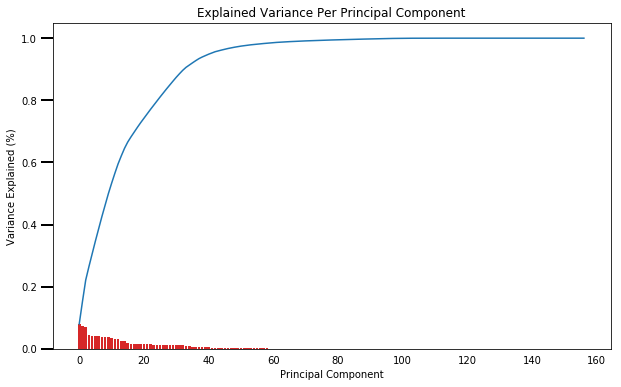

In [156]:
pca, X_train_pca_0 = do_pca(X_train_scaled)
scree_plot(pca)

In [157]:
# 60 components explained most variance
n_components = 60
pca, X_train_pca = do_pca(X_train_scaled, n_components=n_components)
X_train_pca.head()

,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,...,pca_comp_50,pca_comp_51,pca_comp_52,pca_comp_53,pca_comp_54,pca_comp_55,pca_comp_56,pca_comp_57,pca_comp_58,pca_comp_59
6765,-0.647544,-0.821021,-0.134808,-0.061775,-0.270233,-0.169516,0.175963,0.120351,0.365728,0.005267,...,0.062422,0.006593,0.143620,-0.031741,-0.058752,-0.162740,0.141515,-0.007250,-0.081564,0.015943
7390,-1.346277,-0.583497,0.061138,0.442081,0.020067,0.030006,0.015492,-0.250361,-0.069805,-0.244517,...,0.049287,-0.084150,-0.121864,0.017340,0.019121,-0.032948,-0.014460,-0.029242,0.036687,0.009177
7550,-1.414510,-0.080997,0.280728,0.876796,0.154614,0.009546,0.128399,-0.129720,0.053071,0.096322,...,0.016144,-0.037004,-0.089513,-0.001017,0.018311,-0.003448,-0.017145,-0.008652,0.064977,0.031653
13721,-1.206626,-0.585624,-0.200914,0.316783,0.021425,-0.276180,-0.008523,0.039287,0.473285,0.157701,...,-0.018204,0.047542,0.082905,-0.104261,-0.062780,0.012279,-0.032570,0.057360,-0.039040,-0.035263
7774,-1.239140,0.327627,0.223773,0.063752,0.160801,-0.013733,-0.203097,0.268750,-0.078304,-0.008692,...,-0.057894,0.200449,0.448046,-0.006894,-0.234541,0.216067,-0.038175,-0.000697,-0.142248,-0.124821


In [158]:
# transform test
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled))
X_test_pca.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_test_pca.index = X_test_scaled.index

Apply scaling and dimensionality reduction to data with missing values

In [159]:
# predict the values for the missing ages for the portion of data that has missing values
X_predict = data_predict.drop(columns=['age', 'gender', 'income', 'per_id', 'gender_F',\
                                       'gender_M', 'gender_None', 'gender_O', 'gender_enc'])

X_predict_scaled = pd.DataFrame(ss.transform(X_predict))
X_predict_scaled.columns = X_predict.columns
X_predict_scaled.index = X_predict.index

# transform test
X_predict_pca = pd.DataFrame(pca.transform(X_predict_scaled))
X_predict_pca.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_predict_pca.index = X_predict_scaled.index

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


## Predict age

In [10]:
Y_train = train['age']


Y_test = test['age']

In [203]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

params = {
    'max_depth': [7,8],\
    'min_child_weight': np.arange(10,510,10),\
    'n_estimators': [100,150]
}

xgb_age = xgb.XGBRegressor(learning_rate = 0.1,\
                           objective = 'reg:linear',\
                           seed = 42,\
                           gamma = 0.1,\
                           silent = True)

In [204]:
model_age = GridSearchCV(xgb_age, param_grid=params,\
                         scoring='neg_mean_squared_error', n_jobs=4,\
                         cv=skf.split(X_train_pca,Y_train),\
                         verbose=2)

model_age.fit(X_train_pca, Y_train)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 12.6min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 27.2min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 49.4min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 76.6min finished
C:\Users\Josh Lee\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Josh Lee\Anaconda3\lib\site-packages\xgboost-0.80-py3.6.egg\xgboost\sklearn.py:202: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


GridSearchCV(cv=<generator object _BaseKFold.split at 0x00000278A36E39E8>,
       error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [7, 8], 'min_child_weight': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]), 'n_estimators': [100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',

In [205]:
test_pred = model_age.predict(X_test_pca)
test_mse = mean_squared_error(Y_test, test_pred)
test_rmse = np.sqrt(test_mse)
print(test_rmse)

16.488927922716975


In [206]:
model_age.best_params_

{'max_depth': 7, 'min_child_weight': 440, 'n_estimators': 100}

In [213]:
save_model_name = "model_age.pickle.dat"
pickle.dump(model_age.best_estimator_, open(save_model_name, "wb"))
#joblib.dump(model_age.best_estimator_, 'model_age.pkl')

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.BufferedWriter name='model_age.pickle.dat'>
  


In [175]:
# If neccessary
model_age = pickle.load(open('model_age.pickle.dat', "rb"))

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='model_age.pickle.dat'>
  


In [176]:
# fill the missing ages with the predicted values
data_predict['age'] = model_age.predict(X_predict_pca)
data_predict.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,gender,income,per_id,member_year,member_month,member_day,offer_0_n_offers,offer_0_n_succ_offers,offer_0_n_tried_offers,...,offer_8_n_offers_/_total_n_offers,offer_9_n_offers_/_total_n_offers,bogo_n_offers_/_total_n_offers,discount_n_offers_/_total_n_offers,info_n_offers_/_total_n_offers,gender_F,gender_M,gender_None,gender_O,gender_enc
0,54.671452,M,56120.851562,6961,2017,2,12,1.0,0.0,0.0,...,0.0,0.4,0.0,1.0,0.0,0,0,1,0,1
2,48.845165,M,46681.929688,3746,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.5,0,0,1,0,1
4,52.494942,M,46151.882812,10735,2017,8,4,3.0,0.0,0.0,...,0.0,0.0,0.0,0.6,0.4,0,0,1,0,1
6,63.360725,M,86693.132812,9524,2017,9,25,0.0,0.0,0.0,...,0.0,0.4,0.2,0.6,0.2,0,0,1,0,1
7,49.685825,M,49993.160156,6939,2017,10,2,0.0,0.0,0.0,...,0.0,0.0,0.6,0.4,0.0,0,0,1,0,1


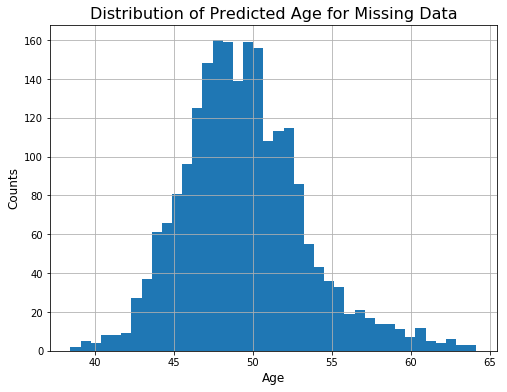

In [177]:
# Distribution of the predicted ages
fig, ax = plt.subplots(figsize=(8,6));
data_predict.age.hist(bins=40, ax=ax)
ax.set_title("Distribution of Predicted Age for Missing Data", fontsize=16)
ax.set_xlabel("Age", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

The model achieved a test RMSE of 16.5. This means that the predicted ages are generally off by approximately 16.5 years. This is certainly not ideal, but considering that the model is solely relying on membership start date and the engineered features, the results are deemed acceptable and I will move on with these predictions.

## Predict Income

The model to predict income will use the features (statistics and ratios) that were created, together with age, gender and membership year.

In [222]:
Y_train = train['income']

Y_test = test['income']

In [223]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

params = {
    'max_depth': [7,8],\
    'min_child_weight': np.arange(10,510,10),\
    'n_estimators': [100,150]
}

xgb_income = xgb.XGBRegressor(learning_rate = 0.1,\
                              objective = 'reg:linear',\
                              seed = 42,\
                              gamma = 0.1,\
                              silent = True)

In [224]:
model_income = GridSearchCV(xgb_income, param_grid=params,\
                            scoring='neg_mean_squared_error', n_jobs=4,\
                            cv=skf.split(X_train_pca,Y_train),\
                            verbose=2)

model_income.fit(X_train_pca, Y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 12.3min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 26.9min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 49.0min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 76.6min finished
C:\Users\Josh Lee\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Josh Lee\Anaconda3\lib\site-packages\xgboost-0.80-py3.6.egg\xgboost\sklearn.py:202: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


GridSearchCV(cv=<generator object _BaseKFold.split at 0x00000278A3776308>,
       error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [7, 8], 'min_child_weight': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]), 'n_estimators': [100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',

In [225]:
test_pred = model_income.predict(X_test_pca)
test_mse = mean_squared_error(Y_test, test_pred)
test_rmse = np.sqrt(test_mse)
print(test_rmse)

13350.184836420594


In [226]:
model_income.best_params_

{'max_depth': 8, 'min_child_weight': 50, 'n_estimators': 100}

In [229]:
save_model_name = "model_income.pickle.dat"
pickle.dump(model_income.best_estimator_, open(save_model_name, "wb"))

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.BufferedWriter name='model_income.pickle.dat'>
  


In [172]:
# If neccessary
model_income = pickle.load(open('model_income.pickle.dat', "rb"))

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='model_income.pickle.dat'>
  


In [173]:
# fill the missing income with the predicted values
data_predict['income'] = model_income.predict(X_predict_pca)
data_predict.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,gender,income,per_id,member_year,member_month,member_day,offer_0_n_offers,offer_0_n_succ_offers,offer_0_n_tried_offers,...,offer_8_n_offers_/_total_n_offers,offer_9_n_offers_/_total_n_offers,bogo_n_offers_/_total_n_offers,discount_n_offers_/_total_n_offers,info_n_offers_/_total_n_offers,gender_F,gender_M,gender_None,gender_O,gender_enc
0,118,M,56120.851562,6961,2017,2,12,1.0,0.0,0.0,...,0.0,0.4,0.0,1.0,0.0,0,0,1,0,1
2,118,M,46681.929688,3746,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.5,0,0,1,0,1
4,118,M,46151.882812,10735,2017,8,4,3.0,0.0,0.0,...,0.0,0.0,0.0,0.6,0.4,0,0,1,0,1
6,118,M,86693.132812,9524,2017,9,25,0.0,0.0,0.0,...,0.0,0.4,0.2,0.6,0.2,0,0,1,0,1
7,118,M,49993.160156,6939,2017,10,2,0.0,0.0,0.0,...,0.0,0.0,0.6,0.4,0.0,0,0,1,0,1


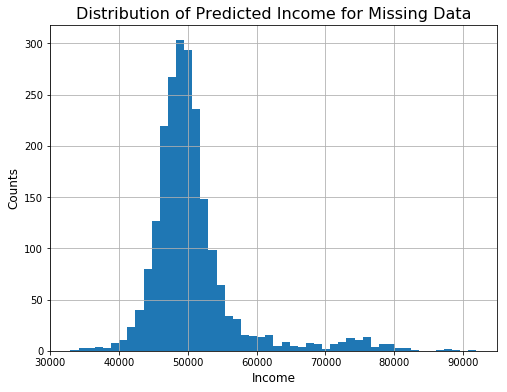

In [174]:
# Distribution of the predicted income
fig, ax = plt.subplots(figsize=(8,6));
data_predict.income.hist(bins=50, ax=ax);
ax.set_title("Distribution of Predicted Income for Missing Data", fontsize=16)
ax.set_xlabel("Income", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

The model for income has a test RMSE of 13,350, which means that the predicted income are off by approximately $13,500. Once again, this is not ideal. Considering the limited availability of information that we can work with, I will move on with these predictions.

# Predict Gender

The model to predict gender will use the features (statistics and ratios) that were created, together with age, income and membership year.

In [160]:
Y_train = train['gender_enc']

Y_test = test['gender_enc']

In [161]:
Y_train.value_counts()

1    6792
0    4904
3     164
Name: gender_enc, dtype: int64

In [162]:
X_train_pca.head()

,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,...,pca_comp_50,pca_comp_51,pca_comp_52,pca_comp_53,pca_comp_54,pca_comp_55,pca_comp_56,pca_comp_57,pca_comp_58,pca_comp_59
6765,-0.647544,-0.821021,-0.134808,-0.061775,-0.270233,-0.169516,0.175963,0.120351,0.365728,0.005267,...,0.062422,0.006593,0.143620,-0.031741,-0.058752,-0.162740,0.141515,-0.007250,-0.081564,0.015943
7390,-1.346277,-0.583497,0.061138,0.442081,0.020067,0.030006,0.015492,-0.250361,-0.069805,-0.244517,...,0.049287,-0.084150,-0.121864,0.017340,0.019121,-0.032948,-0.014460,-0.029242,0.036687,0.009177
7550,-1.414510,-0.080997,0.280728,0.876796,0.154614,0.009546,0.128399,-0.129720,0.053071,0.096322,...,0.016144,-0.037004,-0.089513,-0.001017,0.018311,-0.003448,-0.017145,-0.008652,0.064977,0.031653
13721,-1.206626,-0.585624,-0.200914,0.316783,0.021425,-0.276180,-0.008523,0.039287,0.473285,0.157701,...,-0.018204,0.047542,0.082905,-0.104261,-0.062780,0.012279,-0.032570,0.057360,-0.039040,-0.035263
7774,-1.239140,0.327627,0.223773,0.063752,0.160801,-0.013733,-0.203097,0.268750,-0.078304,-0.008692,...,-0.057894,0.200449,0.448046,-0.006894,-0.234541,0.216067,-0.038175,-0.000697,-0.142248,-0.124821


In [163]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

params = {
    'max_depth': [7,8],\
    'min_child_weight': np.arange(10,510,10),\
    'n_estimators': [100,150]
}

xgb_gender = xgb.XGBClassifier(learning_rate = 0.1,\
                               objective = 'multi:softmax',\
                               seed = 42,\
                               gamma = 0.1,\
                               num_class = 3,\
                               silent = True)

In [164]:
model_gender = GridSearchCV(xgb_gender, param_grid=params,\
                            scoring='f1_micro', n_jobs=4,\
                            cv=skf.split(X_train_pca,Y_train),\
                            verbose=2)

model_gender.fit(X_train_pca, Y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  9.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 33.5min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 65.1min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 116.6min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 168.2min finished
C:\Users\Josh Lee\Anaconda3\lib\site-packages\xgboost-0.80-py3.6.egg\xgboost\sklearn.py:202: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


GridSearchCV(cv=<generator object _BaseKFold.split at 0x000001EBCDF1A308>,
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_class=3, objective='multi:softmax',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [7, 8], 'min_child_weight': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]), 'n_estimators': [100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_tr

In [167]:
#test_pred = model_gender.predict_proba(X_test_pca)
test_pred = model_gender.predict(X_test_pca)
#pd.Series(test_pred).value_counts()
#test_log_loss = log_loss(Y_test, test_pred, labels=[0,1,3])
test_f1 = f1_score(Y_test, test_pred, average='micro')
print(test_f1)

0.5973018549747049


In [165]:
model_gender.best_params_

{'max_depth': 7, 'min_child_weight': 420, 'n_estimators': 100}

In [171]:
save_model_name = "model_gender.pickle.dat"
pickle.dump(model_gender.best_estimator_, open(save_model_name, "wb"))

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.BufferedWriter name='model_gender.pickle.dat'>
  


In [ ]:
# If neccessary
#model_gender = pickle.load(open('model_gender.pickle.dat', "rb"))

In [168]:
# fill the missing income with the predicted values
data_predict['gender_enc'] = model_gender.predict(X_predict_pca)
data_predict.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,gender,income,per_id,member_year,member_month,member_day,offer_0_n_offers,offer_0_n_succ_offers,offer_0_n_tried_offers,...,offer_8_n_offers_/_total_n_offers,offer_9_n_offers_/_total_n_offers,bogo_n_offers_/_total_n_offers,discount_n_offers_/_total_n_offers,info_n_offers_/_total_n_offers,gender_F,gender_M,gender_None,gender_O,gender_enc
0,118,None,NaN,6961,2017,2,12,1.0,0.0,0.0,...,0.0,0.4,0.0,1.0,0.0,0,0,1,0,1
2,118,None,NaN,3746,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.5,0,0,1,0,1
4,118,None,NaN,10735,2017,8,4,3.0,0.0,0.0,...,0.0,0.0,0.0,0.6,0.4,0,0,1,0,1
6,118,None,NaN,9524,2017,9,25,0.0,0.0,0.0,...,0.0,0.4,0.2,0.6,0.2,0,0,1,0,1
7,118,None,NaN,6939,2017,10,2,0.0,0.0,0.0,...,0.0,0.0,0.6,0.4,0.0,0,0,1,0,1


In [169]:
# inverse transform the label encodings back to the original gender values
data_predict['gender'] = gender_encoder.inverse_transform(data_predict['gender_enc'])
data_predict.head()

C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,gender,income,per_id,member_year,member_month,member_day,offer_0_n_offers,offer_0_n_succ_offers,offer_0_n_tried_offers,...,offer_8_n_offers_/_total_n_offers,offer_9_n_offers_/_total_n_offers,bogo_n_offers_/_total_n_offers,discount_n_offers_/_total_n_offers,info_n_offers_/_total_n_offers,gender_F,gender_M,gender_None,gender_O,gender_enc
0,118,M,NaN,6961,2017,2,12,1.0,0.0,0.0,...,0.0,0.4,0.0,1.0,0.0,0,0,1,0,1
2,118,M,NaN,3746,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.5,0,0,1,0,1
4,118,M,NaN,10735,2017,8,4,3.0,0.0,0.0,...,0.0,0.0,0.0,0.6,0.4,0,0,1,0,1
6,118,M,NaN,9524,2017,9,25,0.0,0.0,0.0,...,0.0,0.4,0.2,0.6,0.2,0,0,1,0,1
7,118,M,NaN,6939,2017,10,2,0.0,0.0,0.0,...,0.0,0.0,0.6,0.4,0.0,0,0,1,0,1


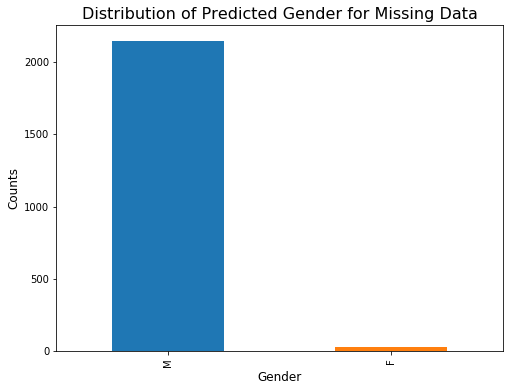

In [170]:
# Distribution of predicted genders
fig, ax = plt.subplots(figsize=(8,6));
data_predict.gender.value_counts().plot(kind='bar', ax=ax)
ax.set_title("Distribution of Predicted Gender for Missing Data", fontsize=16)
ax.set_xlabel("Gender", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

The model for gender has a logloss of approximately 0.72. An interesting observation is that most of the predicted genders are males.

## Build new profile

I will now reconstruct a new profile dataset with the missing values filled in with the predictions. I will need to reverse any encodings done at this stage to maintain consistency with the original datasets.

In [178]:
profile.head()

,age,gender,income,per_id,member_year,member_month,member_day
0,118,None,NaN,6961,2017,2,12
1,55,F,112000.0,398,2017,7,15
2,118,None,NaN,3746,2018,7,12
3,75,F,100000.0,7996,2017,5,9
4,118,None,NaN,10735,2017,8,4


In [179]:
# get portion of data with no missing values
new_profile_no_missing = profile[profile['gender'] != 'None']
new_profile_no_missing.head()

,age,gender,income,per_id,member_year,member_month,member_day
1,55,F,112000.0,398,2017,7,15
3,75,F,100000.0,7996,2017,5,9
5,68,M,70000.0,15043,2018,4,26
8,65,M,53000.0,3728,2018,2,9
12,58,M,51000.0,3059,2017,11,11


In [180]:
# get portion of data with missing values
new_profile_w_missing = profile[profile['gender'] == 'None']
new_profile_w_missing.head()

,age,gender,income,per_id,member_year,member_month,member_day
0,118,None,NaN,6961,2017,2,12
2,118,None,NaN,3746,2018,7,12
4,118,None,NaN,10735,2017,8,4
6,118,None,NaN,9524,2017,9,25
7,118,None,NaN,6939,2017,10,2


In [181]:
# drop age, gender, income. Going to fill these up with the predictions
new_profile_w_missing = new_profile_w_missing[['per_id', 'member_year', 'member_month', 'member_day']]

In [182]:
new_profile_w_missing.head()

,per_id,member_year,member_month,member_day
0,6961,2017,2,12
2,3746,2018,7,12
4,10735,2017,8,4
6,9524,2017,9,25
7,6939,2017,10,2


In [183]:
new_profile_w_missing.shape

(2175, 4)

In [184]:
data_predict_summary = data_predict[['age', 'gender', 'income', 'per_id']]
new_profile_w_missing = pd.merge(new_profile_w_missing, data_predict_summary, on='per_id', how='left')
new_profile_w_missing = new_profile_w_missing[['age', 'gender', 'income', 'per_id', 'member_year', 'member_month', 'member_day']]
new_profile_w_missing.head()

,age,gender,income,per_id,member_year,member_month,member_day
0,54.671452,M,56120.851562,6961,2017,2,12
1,48.845165,M,46681.929688,3746,2018,7,12
2,52.494942,M,46151.882812,10735,2017,8,4
3,63.360725,M,86693.132812,9524,2017,9,25
4,49.685825,M,49993.160156,6939,2017,10,2


In [185]:
new_profile_w_missing.shape

(2175, 7)

In [186]:
# combine both the datasets together
new_profile = pd.concat([new_profile_no_missing, new_profile_w_missing], axis=0)
new_profile.head()

,age,gender,income,per_id,member_year,member_month,member_day
1,55.0,F,112000.0,398,2017,7,15
3,75.0,F,100000.0,7996,2017,5,9
5,68.0,M,70000.0,15043,2018,4,26
8,65.0,M,53000.0,3728,2018,2,9
12,58.0,M,51000.0,3059,2017,11,11


In [187]:
new_profile.shape

(17000, 7)

In [188]:
profile.shape

(17000, 7)

In [189]:
# inverse transform new profile person id back to original hash values
new_profile['id'] = person_enocoder.inverse_transform(new_profile['per_id'])
new_profile.drop(columns=['per_id'], inplace=True)
new_profile.head()

,age,gender,income,member_year,member_month,member_day,id
1,55.0,F,112000.0,2017,7,15,0610b486422d4921ae7d2bf64640c50b
3,75.0,F,100000.0,2017,5,9,78afa995795e4d85b5d9ceeca43f5fef
5,68.0,M,70000.0,2018,4,26,e2127556f4f64592b11af22de27a7932
8,65.0,M,53000.0,2018,2,9,389bc3fa690240e798340f5a15918d5c
12,58.0,M,51000.0,2017,11,11,2eeac8d8feae4a8cad5a6af0499a211d


In [190]:
new_profile.to_csv("new_profile.csv",index=False)

## Pick a few random customers to check if all_data is correct

In [250]:
all_data[all_data["total_n_succ_offers"]>2]

,age,gender,income,per_id,member_year,member_month,member_day,offer_0_n_offers,offer_0_n_succ_offers,offer_0_n_tried_offers,...,offer_8_n_offers_/_total_n_offers,offer_9_n_offers_/_total_n_offers,bogo_n_offers_/_total_n_offers,discount_n_offers_/_total_n_offers,info_n_offers_/_total_n_offers,gender_F,gender_M,gender_None,gender_O,gender_enc
5491,72,M,56000.0,15005,2016,6,9,0.0,0.0,0.0,...,0.0,0.333333,0.166667,0.666667,0.166667,0,1,0,0,1
6542,75,M,85000.0,16246,2016,6,28,0.0,0.0,0.0,...,0.2,0.000000,0.600000,0.200000,0.200000,0,1,0,0,1
8833,40,M,86000.0,14548,2016,7,27,0.0,0.0,0.0,...,0.0,0.333333,0.333333,0.500000,0.166667,0,1,0,0,1
10266,46,F,85000.0,1060,2016,8,27,0.0,0.0,0.0,...,0.0,0.000000,0.666667,0.333333,0.000000,1,0,0,0,0
11218,49,F,98000.0,12996,2016,11,17,0.0,0.0,0.0,...,0.0,0.166667,0.333333,0.666667,0.000000,1,0,0,0,0


In [245]:
transcript.tail()

,event,time,value,per_id,value_type,value_id_amt
306529,transaction,714,{'amount': 1.5899999999999999},12027,amount,1.59
306530,transaction,714,{'amount': 9.53},6913,amount,9.53
306531,transaction,714,{'amount': 3.61},10722,amount,3.61
306532,transaction,714,{'amount': 3.5300000000000002},7881,amount,3.53
306533,transaction,714,{'amount': 4.05},12847,amount,4.05


In [251]:
transcript[transcript['per_id']==15005]

,event,time,value,per_id,value_type,value_id_amt
3978,offer received,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},15005,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
16357,offer viewed,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},15005,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
28382,transaction,42,{'amount': 14.47},15005,amount,14.47
28383,offer completed,42,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,15005,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9
34549,transaction,66,{'amount': 9.92},15005,amount,9.92
35952,transaction,72,{'amount': 17.59},15005,amount,17.59
48851,transaction,138,{'amount': 4.69},15005,amount,4.69
57220,offer received,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},15005,offer id,5a8bc65990b245e5a138643cd4eb9837
66999,offer viewed,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},15005,offer id,5a8bc65990b245e5a138643cd4eb9837
67000,transaction,168,{'amount': 9.85},15005,amount,9.85


In [252]:
all_data[all_data['per_id']==15005][['offer_0_n_succ_offers', 'offer_1_n_succ_offers', 'offer_2_n_succ_offers',\
                                   'offer_3_n_succ_offers', 'offer_4_n_succ_offers', 'offer_5_n_succ_offers',\
                                   'offer_6_n_succ_offers', 'offer_7_n_succ_offers', 'offer_8_n_succ_offers',\
                                   'offer_9_n_succ_offers'
                                  ]]

,offer_0_n_succ_offers,offer_1_n_succ_offers,offer_2_n_succ_offers,offer_3_n_succ_offers,offer_4_n_succ_offers,offer_5_n_succ_offers,offer_6_n_succ_offers,offer_7_n_succ_offers,offer_8_n_succ_offers,offer_9_n_succ_offers
5491,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [253]:
all_data[all_data['per_id']==15005][['offer_0_total_spent', 'offer_1_total_spent', 'offer_2_total_spent',\
                                   'offer_3_total_spent', 'offer_4_total_spent', 'offer_5_total_spent',\
                                   'offer_6_total_spent', 'offer_7_total_spent', 'offer_8_total_spent',\
                                   'offer_9_total_spent', 'no_offer_total_spent'
                                  ]]

,offer_0_total_spent,offer_1_total_spent,offer_2_total_spent,offer_3_total_spent,offer_4_total_spent,offer_5_total_spent,offer_6_total_spent,offer_7_total_spent,offer_8_total_spent,offer_9_total_spent,no_offer_total_spent
5491,0.0,0.0,30.05,0.0,0.0,9.85,0.0,0.0,0.0,12.53,110.73


## Some EDA

In [21]:
transcript_offer_received.tail(10)

,time_received,per_id,offer_id,age,gender,income,member_year,member_month,member_day,difficulty,duration,offer_type,reward,email,mobile,social,web
149456,576,16356,6,64,M,51000.0,2018,1,4,5,7,bogo,5,1,1,0,1
149457,576,13480,3,118,None,NaN,2018,3,5,0,4,informational,0,1,1,0,1
149458,576,6834,0,21,M,39000.0,2016,5,11,20,10,discount,5,1,0,0,1
149459,576,16539,5,47,M,93000.0,2016,5,29,0,3,informational,0,1,1,1,0
149460,576,11114,5,57,M,77000.0,2018,1,10,0,3,informational,0,1,1,1,0
149461,576,13891,7,56,M,51000.0,2016,10,23,10,7,bogo,10,1,1,1,0
149462,576,13523,2,60,M,113000.0,2018,5,5,10,7,discount,2,1,1,0,1
149463,576,7264,1,45,F,54000.0,2018,6,4,7,7,discount,3,1,1,1,1
149464,576,10567,7,83,F,50000.0,2016,3,7,10,7,bogo,10,1,1,1,0
149465,576,15177,3,62,F,82000.0,2017,7,22,0,4,informational,0,1,1,0,1


In [25]:
transcript_offer_received[transcript_offer_received['offer_id']==0].shape

(7668, 17)

In [46]:
offer_0_total = all_data['offer_0_n_offers'].sum()
offer_0_succ = all_data['offer_0_n_succ_offers'].sum()
offer_0_tried = all_data['offer_0_n_tried_offers'].sum()
offer_0_succ_tried = offer_0_succ + offer_0_tried
offer_0_failed = offer_0_total - offer_0_succ_tried

offer_1_total = all_data['offer_1_n_offers'].sum()
offer_1_succ = all_data['offer_1_n_succ_offers'].sum()
offer_1_tried = all_data['offer_1_n_tried_offers'].sum()
offer_1_succ_tried = offer_1_succ + offer_1_tried
offer_1_failed = offer_1_total - offer_1_succ_tried

offer_2_total = all_data['offer_2_n_offers'].sum()
offer_2_succ = all_data['offer_2_n_succ_offers'].sum()
offer_2_tried = all_data['offer_2_n_tried_offers'].sum()
offer_2_succ_tried = offer_2_succ + offer_2_tried
offer_2_failed = offer_2_total - offer_2_succ_tried

offer_3_total = all_data['offer_3_n_offers'].sum()
offer_3_succ = all_data['offer_3_n_succ_offers'].sum()
offer_3_tried = all_data['offer_3_n_tried_offers'].sum()
offer_3_succ_tried = offer_3_succ + offer_3_tried
offer_3_failed = offer_3_total - offer_3_succ_tried

offer_4_total = all_data['offer_4_n_offers'].sum()
offer_4_succ = all_data['offer_4_n_succ_offers'].sum()
offer_4_tried = all_data['offer_4_n_tried_offers'].sum()
offer_4_succ_tried = offer_4_succ + offer_4_tried
offer_4_failed = offer_4_total - offer_4_succ_tried

offer_5_total = all_data['offer_5_n_offers'].sum()
offer_5_succ = all_data['offer_5_n_succ_offers'].sum()
offer_5_tried = all_data['offer_5_n_tried_offers'].sum()
offer_5_succ_tried = offer_5_succ + offer_5_tried
offer_5_failed = offer_5_total - offer_5_succ_tried

offer_6_total = all_data['offer_6_n_offers'].sum()
offer_6_succ = all_data['offer_6_n_succ_offers'].sum()
offer_6_tried = all_data['offer_6_n_tried_offers'].sum()
offer_6_succ_tried = offer_6_succ + offer_6_tried
offer_6_failed = offer_6_total - offer_6_succ_tried

offer_7_total = all_data['offer_7_n_offers'].sum()
offer_7_succ = all_data['offer_7_n_succ_offers'].sum()
offer_7_tried = all_data['offer_7_n_tried_offers'].sum()
offer_7_succ_tried = offer_7_succ + offer_7_tried
offer_7_failed = offer_7_total - offer_7_succ_tried

offer_8_total = all_data['offer_8_n_offers'].sum()
offer_8_succ = all_data['offer_8_n_succ_offers'].sum()
offer_8_tried = all_data['offer_8_n_tried_offers'].sum()
offer_8_succ_tried = offer_8_succ + offer_8_tried
offer_8_failed = offer_8_total - offer_8_succ_tried

offer_9_total = all_data['offer_9_n_offers'].sum()
offer_9_succ = all_data['offer_9_n_succ_offers'].sum()
offer_9_tried = all_data['offer_9_n_tried_offers'].sum()
offer_9_succ_tried = offer_9_succ + offer_9_tried
offer_9_failed = offer_9_total - offer_9_succ_tried

succ_list = [offer_0_succ, offer_1_succ, offer_2_succ, offer_3_succ,\
             offer_4_succ, offer_5_succ, offer_6_succ, offer_7_succ,\
             offer_8_succ, offer_9_succ
            ]

tried_list = [offer_0_tried, offer_1_tried, offer_2_tried, offer_3_tried,\
              offer_4_tried, offer_5_tried, offer_6_tried, offer_7_tried,\
              offer_8_tried, offer_9_tried
             ]

failed_list = [offer_0_failed, offer_1_failed, offer_2_failed, offer_3_failed,\
               offer_4_failed, offer_5_failed, offer_6_failed, offer_7_failed,\
               offer_8_failed, offer_9_failed
              ]

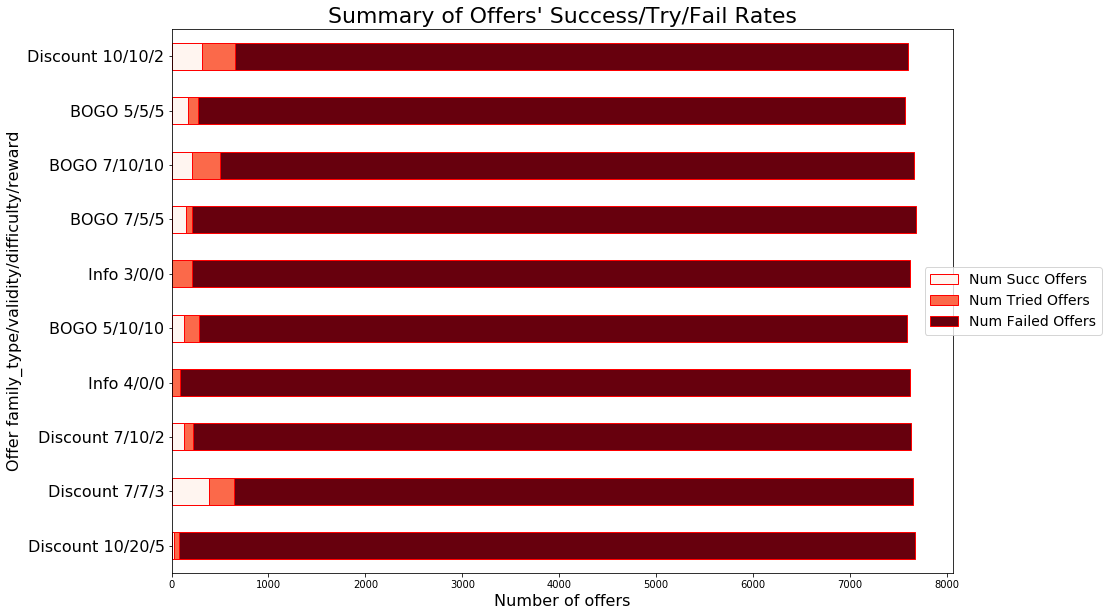

In [254]:
df = pd.DataFrame({'Num Succ Offers' : succ_list,'Num Tried Offers' : tried_list,\
                   'Num Failed Offers' : failed_list}
                 )

fig, ax = plt.subplots();
fig.set_size_inches(14,10);

# https://stackoverflow.com/questions/44338623/horizontal-stacked-bar-chart-in-python-giving-multiple-charts-in-jupyter-noteboo
# https://stackoverflow.com/questions/49601890/display-label-stacked-barh-with-values-from-dataframe
df.plot.barh(stacked=True, colormap='Reds', edgecolor='red', ax=ax);

ind = np.arange(9)

ax.set_title("Summary of Offers' Success/Try/Fail Rates", fontsize=22);
ax.set_yticklabels(['Discount 10/20/5', 'Discount 7/7/3', 'Discount 7/10/2', 'Info 4/0/0',\
                 'BOGO 5/10/10', 'Info 3/0/0', 'BOGO 7/5/5', 'BOGO 7/10/10',\
                 'BOGO 5/5/5', 'Discount 10/10/2'], fontsize=16
                  )
ax.set_ylabel("Offer family_type/validity/difficulty/reward", fontsize=16)
ax.set_xlabel("Number of offers", fontsize=16)
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), fontsize=14);

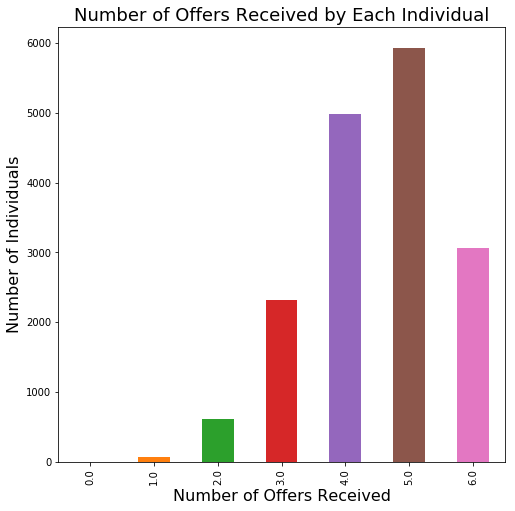

In [259]:
fig, ax = plt.subplots(figsize=(8,8));
all_data.total_n_offers.value_counts().sort_index().plot(kind='bar', ax=ax);
ax.set_title("Number of Offers Received by Each Individual", fontsize=18);
ax.set_xlabel("Number of Offers Received", fontsize=16);
ax.set_ylabel("Number of Individuals", fontsize=16);

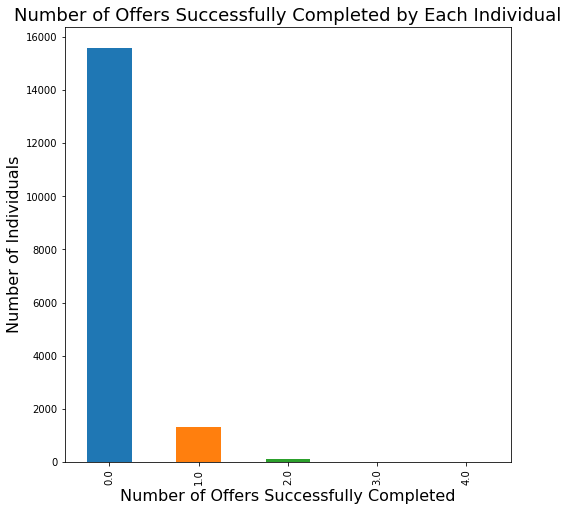

In [258]:
fig, ax = plt.subplots(figsize=(8,8));
all_data.total_n_succ_offers.value_counts().sort_index().plot(kind='bar', ax=ax);
ax.set_title("Number of Offers Successfully Completed by Each Individual", fontsize=18);
ax.set_xlabel("Number of Offers Successfully Completed", fontsize=16);
ax.set_ylabel("Number of Individuals", fontsize=16);

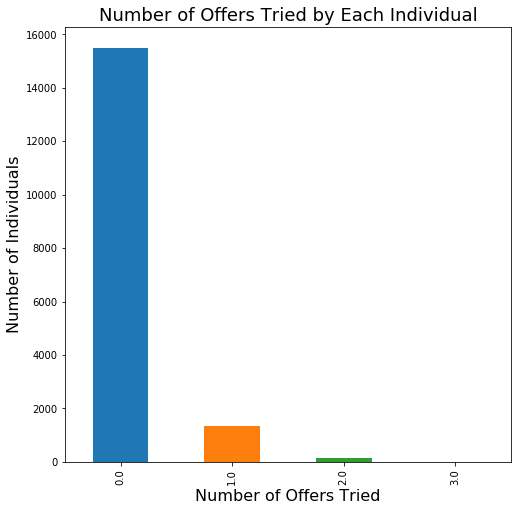

In [260]:
fig, ax = plt.subplots(figsize=(8,8));
all_data.total_n_tried_offers.value_counts().sort_index().plot(kind='bar', ax=ax);
ax.set_title("Number of Offers Tried by Each Individual", fontsize=18);
ax.set_xlabel("Number of Offers Tried", fontsize=16);
ax.set_ylabel("Number of Individuals", fontsize=16);

In [203]:
all_data.total_n_succ_offers.value_counts()

0.0    15596
1.0     1303
2.0       96
3.0        4
4.0        1
Name: total_n_succ_offers, dtype: int64

In [204]:
all_data.total_n_tried_offers.value_counts()

0.0    15502
1.0     1361
2.0      129
3.0        8
Name: total_n_tried_offers, dtype: int64